In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d
import numpy as np
from scipy.optimize import curve_fit
import seaborn as sns


In [2]:
# Load your CSV file
data = pd.read_excel('data.xlsx')  # Replace with your actual filename

# Generating features 

In [3]:
resolution_m = 60e-6 #m
resolution_cm = 60e-4 #cm
sample_size_pixel = 400
sample_length_cm = resolution_cm * sample_size_pixel

data['cluster_density'] = data['num_cluster'] / (sample_length_cm**3)
data['pore_density'] = data['num_pores'] / (sample_length_cm**3)
data['throat_density'] = data['num_throats'] / (sample_length_cm**3)
data['anisotropy_MIL'] = 1 - ( (data['MIL_x'] + data['MIL_y']) / (2*data['MIL_z']))
data['anisotropy_Perm'] = (data['Perm_x'] + data['Perm_y']) / (2*data['Perm_z'])
data['anisotropy_Tort'] = (data['Tort_x'] + data['Tort_y']) / (2*data['Tort_z'])
data['avg_pore_diameter'] = data['avg_pore_diameter'] * 1e6
data['avg_throat_diameter'] = data['avg_throat_diameter'] * 1e6
data['density'] = (1- (data['porosity']/100)) * 0.917 # density g/cm3
data['D_eff__by__D_air'] = (data['porosity']/100)/data['Tort_z'] # Normalized diffusivity
data['log_perm_z'] = np.log10(data['Perm_z'])
data['log_log_perm_z'] = np.log10(data['log_perm_z'])
data.columns

D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Index(['name', 'number_of_regions', 'starting_layer', 'ending_layer', 'depth',
       'sample_volume', 'porosity', 'open_pores', 'cuted_pores',
       'isolated_pores', 'euler_density', 'SSA', 'MIL_x', 'MIL_y', 'MIL_z',
       'Perm_x', 'Perm_y', 'Perm_z', 'Tort_x', 'Tort_y', 'Tort_z',
       'sph_ice_cluster', 'num_pores', 'num_throats', 'coordination_number',
       'std_coordination_number', 'avg_pore_volume', 'avg_pore_diameter',
       'avg_throat_diameter', 'avg_throat_length', 'max_connections',
       'median_connections', 'num_cluster', 'max_cluster_size',
       'avg_cluster_size', 'avg_pore_surface_area', 'avg_throat_area',
       'new_depth', 'cluster_density', 'pore_density', 'throat_density',
       'anisotropy_MIL', 'anisotropy_Perm', 'anisotropy_Tort', 'density',
       'D_eff__by__D_air', 'log_perm_z', 'log_log_perm_z'],
      dtype='object')

In [9]:
HL["dw"].shape

(140,)

C:\Users\Faramarz\AppData\Local\Temp\ipykernel_18248\330320918.py:94: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  axes[1].scatter(residuals[:7000], your_data["new_depth"][:7000], color='gray', s=4, label='Residuals Micro-CT data')


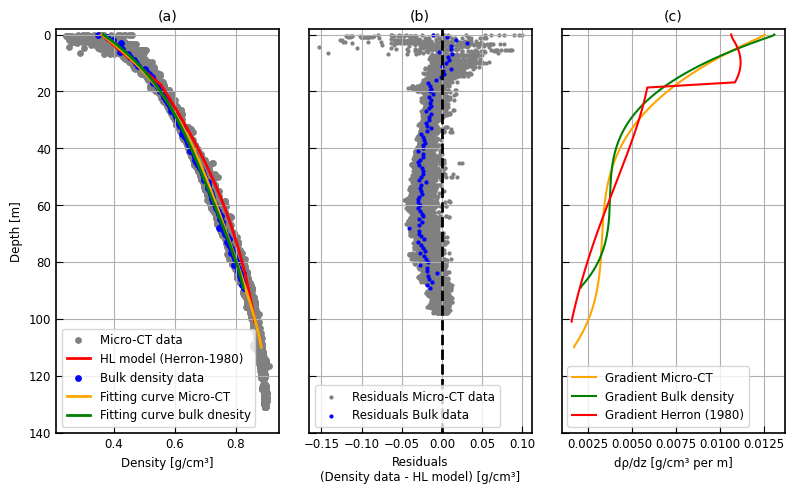

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.size": 8.5,
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5
})

# ------------------------
# INPUTS (Kohnen Station)
# ------------------------
T_mean = -44.0 + 273.15   # mean annual temperature in Kelvin
A = 0.064  # accumulation rate in m ice eq. / year

# Load datasets
your_data = data.copy()
your_data = your_data.sort_values('new_depth')
data_bulk_density = pd.read_excel('Density_Bagmean_Vol_B40_iceDB.xlsx')
HL = pd.read_csv('HL_Density_depth_T44_6A66_2D_036.csv')

# Convert units if needed (assuming your_data["density"] is already in g/cm3)
# Ensure HL['dw'] is density in g/cm3 and HL['zw'] depth in m

# ------------------------
# Residuals (Micro-CT - HL model)
# ------------------------
# Interpolate HL model onto micro-CT depths
hl_interp = np.interp(your_data["new_depth"], HL["zw"], HL["dw"])
residuals = your_data["density"] - hl_interp

hl_interp_2 = np.interp(data_bulk_density['Depthtop_m'], HL["zw"], HL["dw"])
residuals_2 = data_bulk_density['Bulkdensity_gcm3'] - hl_interp_2


# ------------------------
# Plotting
# ------------------------

# Fit polynomial (degree 4)
x = your_data["density"]
y = your_data["new_depth"]
coeffs = np.polyfit(y, x, deg=4)
poly = np.poly1d(coeffs)
y_fit_data = np.linspace(y.min(), 110, 200)
x_fit_data = poly(y_fit_data)


# Fit polynomial (degree 4)
x = data_bulk_density['Bulkdensity_gcm3']
y = data_bulk_density['Depthtop_m']
coeffs = np.polyfit(y, x, deg=4)
poly = np.poly1d(coeffs)
y_fit_bulk = np.linspace(y.min(), y.max(), 200)
x_fit_bulk= poly(y_fit_bulk)


# ------------------------
# Gradient (dρ/dz)
# ------------------------
# Numerical derivative for HL and Micro-CT
grad_micro = np.gradient(x_fit_data, y_fit_data)
grad_HL = np.gradient(HL["dw"], HL["zw"])
grad_bulk = np.gradient(x_fit_bulk, y_fit_bulk)

fig, axes = plt.subplots(1, 3, figsize=(8,5), sharey=True)

# ---- (1) Main density profile
axes[0].scatter(your_data["density"], your_data["new_depth"], label="Micro-CT data", 
                color='gray', s=15)
axes[0].plot(HL['dw'], HL['zw'], label="HL model (Herron-1980)", 
             linestyle="-", linewidth=2, color='red')
axes[0].scatter(data_bulk_density['Bulkdensity_gcm3'], data_bulk_density['Depthtop_m'], 
                label="Bulk density data", color='blue', s=15)
axes[0].plot(x_fit_data, y_fit_data, label="Fitting curve Micro-CT", 
             linestyle="-", linewidth=2, color='orange')
axes[0].plot(x_fit_bulk, y_fit_bulk, label="Fitting curve bulk dnesity", 
             linestyle="-", linewidth=2, color='green')

axes[0].set_ylim(-2, 140)
axes[0].invert_yaxis()
axes[0].set_xlabel("Density [g/cm³]")
axes[0].set_ylabel("Depth [m]")
axes[0].legend()
axes[0].grid(True)
axes[0].set_title('(a)')

# ---- (2) Residuals
axes[1].scatter(residuals[:7000], your_data["new_depth"][:7000], color='gray', s=4, label='Residuals Micro-CT data')
axes[1].scatter(residuals_2[:100], data_bulk_density['Depthtop_m'][:100], color='blue', s=4, label='Residuals Bulk data')
axes[1].axvline(0, color='black', linestyle="--",linewidth=2)
axes[1].set_xlabel("Residuals\n(Density data - HL model) [g/cm³]")
axes[1].grid(True)
axes[1].set_title('(b)')
axes[1].legend()

# ---- (3) Gradient
axes[2].plot(grad_micro, y_fit_data, color='orange',label='Gradient Micro-CT')
axes[2].plot(grad_bulk, y_fit_bulk, color='green',label='Gradient Bulk density')
axes[2].plot(grad_HL,HL["zw"], color='red',label='Gradient Herron (1980)')
#axes[2].axvline(0, color='black', linestyle="--",linewidth=2)
axes[2].set_xlabel("dρ/dz [g/cm³ per m]")
axes[2].grid(True)
axes[2].set_title('(c)')
plt.tight_layout()
axes[2].legend()
plt.savefig("density_HL_Bulk.png", dpi=400)
plt.show()


# Densification models 

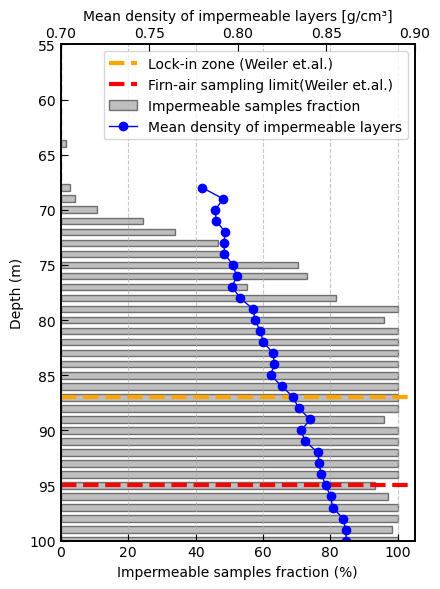

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


plt.rcParams.update({
    "font.size":10,
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5
})



df = data.sort_values(by="new_depth").copy()

# --- Parameters ---
N_expected = 80  # expected number of samples per meter
threshold = 5e-12  # impermeable cutoff

# Mark impermeable
df["impermeable"] = df["Perm_z"] < threshold

# Bin into meters
df["meter_bin"] = df["new_depth"].astype(int)

# Count per meter
counts = df.groupby("meter_bin")["impermeable"].sum()
mean_density = df[df["impermeable"]].groupby("meter_bin")["density"].mean()

# Convert to percentage of expected (out of 80)
totals = df.groupby("meter_bin").size()
percent = (counts / totals) * 100

# Fill missing bins with 0
all_bins = pd.Series(0, index=np.arange(int(df["new_depth"].min()), int(df["new_depth"].max())+1))
percent = all_bins.add(percent, fill_value=0)

# For density, missing bins → NaN (no impermeable sample in that bin)
mean_density = mean_density.reindex(all_bins.index)

# --- Plot ---
fig, ax1 = plt.subplots(figsize=(4.5,6))

# Bar plot (fraction of impermeable layers)
ax1.barh(percent.index, percent.values, height=0.6, color='gray', edgecolor='black', alpha=0.5,label='Impermeable samples fraction')
ax1.set_ylabel("Depth (m)")
ax1.set_xlabel("Impermeable samples fraction (%)")
ax1.set_ylim(55, 100)
ax1.invert_yaxis()
ax1.grid(axis='x', linestyle='--', alpha=0.7)
ax1.axhline(87, color='Orange', linestyle="--",linewidth=3, label='Lock-in zone (Weiler et.al.)', alpha=1)
ax1.axhline(95, color='Red', linestyle="--",linewidth=3, label='Firn-air sampling limit(Weiler et.al.)')

# Second x-axis for mean density
ax2 = ax1.twiny()
ax2.plot(mean_density.values[65:], mean_density.index[65:], color='blue', marker='o',
         linestyle='-', linewidth=1, label='Mean density of impermeable layers')
ax2.set_xlabel("Mean density of impermeable layers [g/cm³]")
ax2.set_xlim(0.7,0.9)

# --- Combine legends ---
lines_labels = ax1.get_legend_handles_labels()
lines_labels2 = ax2.get_legend_handles_labels()
handles = lines_labels[0] + lines_labels2[0]
labels = lines_labels[1] + lines_labels2[1]

ax1.legend(handles, labels, loc="upper right")  # pick loc to avoid overlap with data
plt.tight_layout()
plt.savefig('impermeable_fraction_with_density.png', dpi=400)
plt.show()


name  number_of_regions  starting_layer  ending_layer  depth  \
8860    Bag5                  1           11200         11600      5   
7166    Bag7                  1           12400         12800      7   
5977   Bag64                  3             600          1000     65   
6294   Bag68                  4            2800          3200     69   
6336   Bag68                  2            7800          8200     69   
...      ...                ...             ...           ...    ...   
2313  Bag130                  2           15400         15800    131   
2315  Bag130                  2           15600         16000    131   
2316  Bag130                  2           15800         16200    131   
2318  Bag130                  2           16000         16400    131   
2320  Bag130                  2           16200         16600    131   

      sample_volume  porosity  open_pores  cuted_pores  isolated_pores  ...  \
8860       64000000     66.94      66.937        0.000           0.002  ...   
7166       64000000     68.44      68.390        0.023           0.029  ...   
5977       64000000     14.74      11.092        1.858           1.793  ...   
6294       64000000     15.02      12.036        1.377           1.609  ...   
6336       64000000     14.86      10.073        2.465           2.317  ...   
...             ...       ...         ...          ...             ...  ...   
2313       64000000      2.51       0.000        0.219           2.290  ...   
2315       64000000      2.49       0.000        0.230           2.258  ...   
2316       64000000      2.45       0.000        0.245           2.204  ...   
2318       64000000      2.53       0.000        0.251           2.284  ...   
2320       64000000      2.48       0.000        0.239           2.244  ...   

      throat_density  anisotropy_MIL  anisotropy_Perm  anisotropy_Tort  \
8860     1955.873843        0.156546        -0.975758         1.239820   
7166     1976.490162        0.107245        -0.028877         1.122886   
5977      774.450231        0.071080         2.460534         0.581019   
6294      674.913194        0.053633         3.641968         0.456143   
6336      664.641204        0.049629        18.117482         0.104567   
...              ...             ...              ...              ...   
2313       52.589699       -0.006284              NaN              NaN   
2315       50.347222       -0.026784              NaN              NaN   
2316       51.938657       -0.009269              NaN              NaN   
2318       52.951389        0.005635              NaN              NaN   
2320       54.108796        0.010769              NaN              NaN   

       density  D_eff__by__D_air  log_perm_z  log_log_perm_z  impermeable  \
8860  0.303160          0.425655         NaN             NaN         True   
7166  0.289405          0.351093         NaN             NaN         True   
5977  0.781834          0.000761  -11.508436             NaN         True   
6294  0.779267          0.001018  -11.390640             NaN         True   
6336  0.780734          0.000364  -11.781996             NaN         True   
...        ...               ...         ...             ...          ...   
2313  0.893983          0.000000        -inf             NaN         True   
2315  0.894167          0.000000        -inf             NaN         True   
2316  0.894534          0.000000        -inf             NaN         True   
2318  0.893800          0.000000        -inf             NaN         True   
2320  0.894258          0.000000        -inf             NaN         True   

      meter_bin  
8860          4  
7166          6  
5977         64  
6294         68  
6336         68  
...         ...  
2313        130  
2315        130  
2316        130  
2318        130  
2320        130  

[3658 rows x 50 columns]

# Densification and pore network features

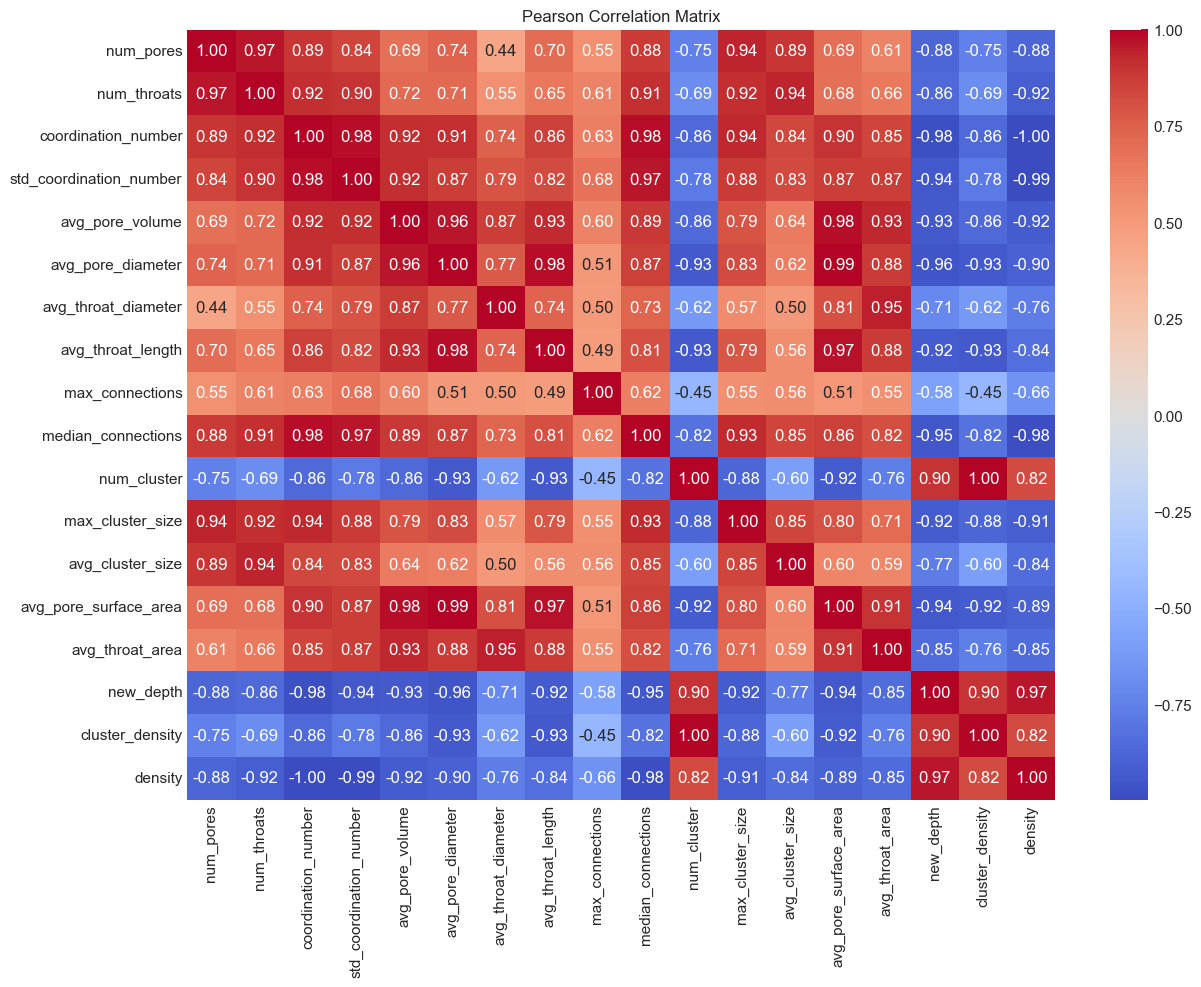

'\n# Plot Spearman correlation\nplt.figure(figsize=(14, 10))\nsns.heatmap(corr_spearman, annot=True, cmap=\'coolwarm\', fmt=".2f")\nplt.title(\'Spearman Correlation Matrix\')\nplt.show()'

In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

features = [
    'num_pores', 'num_throats', 'coordination_number',
    'std_coordination_number', 'avg_pore_volume', 'avg_pore_diameter',
    'avg_throat_diameter', 'avg_throat_length', 'max_connections',
    'median_connections', 'num_cluster', 'max_cluster_size',
    'avg_cluster_size', 'avg_pore_surface_area', 'avg_throat_area',
    'new_depth', 'cluster_density','density'
]

df = data.copy()
#df = df[df["Perm_z"] > 5e-14]
#df = df[df["Perm_z"] < 5e-6]
X = df[features].dropna()

density = df['new_depth'].loc[X.index]

# === Correlation Matrices ===
corr_pearson = X.corr(method='pearson')
corr_spearman = X.corr(method='spearman')

# Plot Pearson correlation
plt.figure(figsize=(14, 10))
sns.heatmap(corr_pearson, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Pearson Correlation Matrix')
plt.show()
'''
# Plot Spearman correlation
plt.figure(figsize=(14, 10))
sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Spearman Correlation Matrix')
plt.show()'''



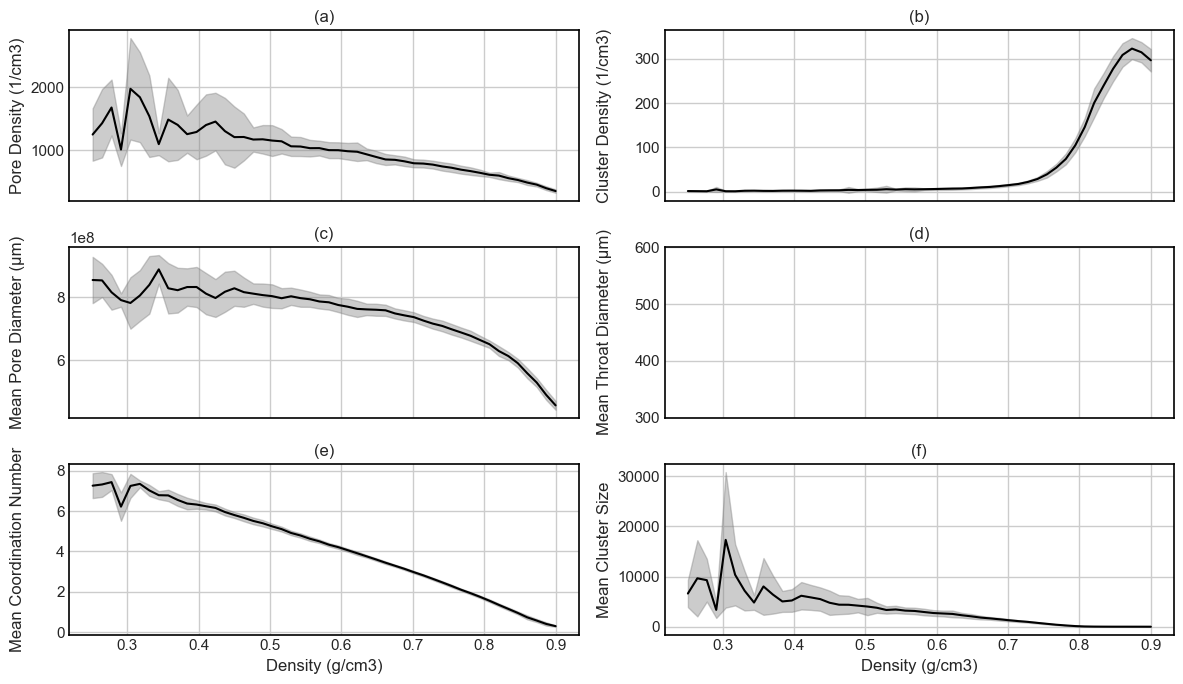

In [55]:

from scipy.stats import binned_statistic


# Bin the data (optional: change number of bins as needed)
def plot_avg(x,y):
    num_bins = 50
    bin_means, bin_edges, _ = binned_statistic(x, y, statistic='mean', bins=num_bins)
    bin_std, _, _ = binned_statistic(x, y, statistic='std', bins=num_bins)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    return bin_centers , bin_means,bin_std
# Bin centers


fig, axes = plt.subplots(3, 2,sharex='col', figsize=(12, 7))

x , y = df['density'], df['pore_density']
bin_centers , bin_means,bin_std = plot_avg(x,y)

axes[0,0].plot(bin_centers, bin_means, label='Mean of y', color='black')
axes[0,0].fill_between(bin_centers, bin_means - bin_std, bin_means + bin_std, color='gray', alpha=0.4, label='±1 std dev')
#axes[0,0].set_xlabel('Density (g/cm3)')
axes[0,0].set_ylabel('Pore Density (1/cm3)')
axes[0,0].set_title('(a)')


x , y = df['density'], df['cluster_density']
bin_centers , bin_means,bin_std = plot_avg(x,y)

axes[0,1].plot(bin_centers, bin_means, label='Mean of y', color='black')
axes[0,1].fill_between(bin_centers, bin_means - bin_std, bin_means + bin_std, color='gray', alpha=0.4, label='±1 std dev')
#axes[0,1].set_xlabel('Density (g/cm3)')
axes[0,1].set_ylabel('Cluster Density (1/cm3)')
axes[0,1].set_title('(b)')



x , y = df['density'], df['avg_pore_diameter']
bin_centers , bin_means,bin_std = plot_avg(x,y)

axes[1,0].plot(bin_centers, bin_means, label='Mean of y', color='black')
axes[1,0].fill_between(bin_centers, bin_means - bin_std, bin_means + bin_std, color='gray', alpha=0.4, label='±1 std dev')
#axes[1,0].set_xlabel('Density (g/cm3)')
axes[1,0].set_ylabel('Mean Pore Diameter (μm)')
axes[1,0].set_title('(c)')


x , y = df['density'], df['avg_throat_diameter']
bin_centers , bin_means,bin_std = plot_avg(x,y)

axes[1,1].plot(bin_centers, bin_means, label='Mean of y', color='black')
axes[1,1].fill_between(bin_centers, bin_means - bin_std, bin_means + bin_std, color='gray', alpha=0.4, label='±1 std dev')
#axes[1,1].set_xlabel('Density (g/cm3)')
axes[1,1].set_ylabel('Mean Throat Diameter (μm)')
axes[1,1].set_ylim(300,600)
axes[1,1].set_title('(d)')



x , y = df['density'], df['coordination_number']
bin_centers , bin_means,bin_std = plot_avg(x,y)

axes[2,0].plot(bin_centers, bin_means, label='Mean of y', color='black')
axes[2,0].fill_between(bin_centers, bin_means - bin_std, bin_means + bin_std, color='gray', alpha=0.4, label='±1 std dev')
axes[2,0].set_xlabel('Density (g/cm3)')
axes[2,0].set_ylabel('Mean Coordination Number')
axes[2,0].set_title('(e)')


x , y = df['density'], df['avg_cluster_size']
bin_centers , bin_means,bin_std = plot_avg(x,y)

axes[2,1].plot(bin_centers, bin_means, label='Mean of y', color='black')
axes[2,1].fill_between(bin_centers, bin_means - bin_std, bin_means + bin_std, color='gray', alpha=0.4, label='±1 std dev')
axes[2,1].set_xlabel('Density (g/cm3)')
axes[2,1].set_ylabel('Mean Cluster Size')
axes[2,1].set_title('(f)')

fig.align_ylabels()
plt.tight_layout()
plt.savefig('density_network.png',dpi=400)
plt.show()

Top feature loadings for PC1 and PC2:
                               PC1       PC2       PC3
Explained Variance (%)   82.016028  8.045158  4.884294
coordination_number       0.257564  0.082064  0.013510
std_coordination_number   0.251604  0.084473  0.183571
median_connections        0.251383  0.120609  0.045202
avg_pore_diameter         0.247178 -0.216988 -0.118349
avg_pore_volume           0.247169 -0.210454  0.120937
avg_pore_surface_area     0.245329 -0.259438 -0.055967
max_cluster_size          0.242021  0.197070 -0.218197
avg_throat_length         0.237915 -0.268678 -0.150943
avg_throat_area           0.230940 -0.257472  0.266696
num_throats               0.228444  0.378572  0.009567
num_pores                 0.225714  0.356688 -0.199868
avg_cluster_size          0.208869  0.426916  0.052951
avg_throat_diameter       0.202846 -0.304426  0.443855
max_connections           0.164952  0.176288  0.534157
num_cluster              -0.234612  0.158839  0.351397
cluster_density          -0

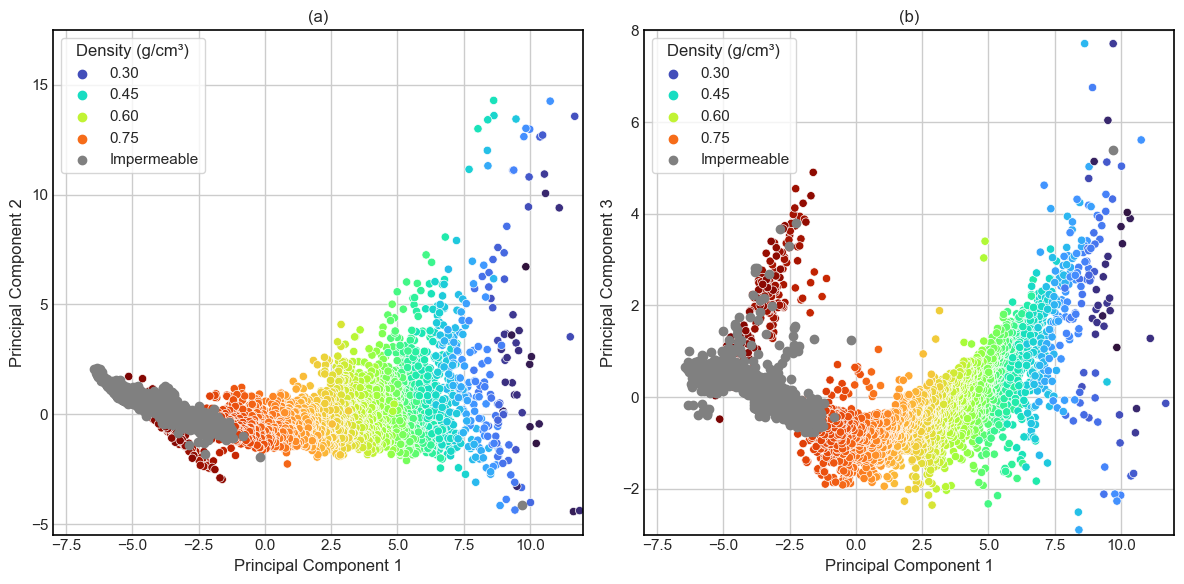

In [61]:
# === PCA Analysis ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
pca_result = pca.fit_transform(X_scaled)

# Explained variance
explained_var = pca.explained_variance_ratio_
cumulative_var = explained_var.cumsum()

# PCA Loadings (feature contribution to components)
loadings = pd.DataFrame(
    pca.components_.T, 
    columns=[f'PC{i+1}' for i in range(len(features))], 
    index=features
)


explained_var = pca.explained_variance_ratio_
cumulative_var = explained_var.cumsum()
loadings.loc['Explained Variance (%)'] = explained_var * 100

print("Top feature loadings for PC1 and PC2:")
print(loadings[['PC1', 'PC2', 'PC3',]].sort_values('PC1', ascending=False))

# === PCA Scatter Plot ===
pca_df = pd.DataFrame(pca_result[:, :3], columns=['PC1', 'PC2','PC3'])
pca_df['density'] = df['density'].values
pca_df['new_depth'] = X['new_depth'].values

# Add permeability info
pca_df['impermeable'] = df['Perm_z'].values < 1e-14

# Create the 2x2 subplot figure
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# --- Plot 1: PC1 vs PC2 ---
# First plot permeable samples (colored by density)
sns.scatterplot(
    ax=axes[0], data=pca_df[~pca_df['impermeable']], 
    x='PC1', y='PC2', hue='density', palette='turbo'
)
# Then overlay impermeable samples in gray
axes[0].scatter(
    pca_df.loc[pca_df['impermeable'], 'PC1'], 
    pca_df.loc[pca_df['impermeable'], 'PC2'], 
    color='gray', label='Impermeable'
)
axes[0].set_title('(a)')
axes[0].legend(title='Density (g/cm³)', loc='upper left')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')
axes[0].set_xlim(-8, 12)
# --- Plot 2: PC1 vs PC3 ---
sns.scatterplot(
    ax=axes[1], data=pca_df[~pca_df['impermeable']], 
    x='PC1', y='PC3', hue='density', palette='turbo'
)
axes[1].scatter(
    pca_df.loc[pca_df['impermeable'], 'PC1'], 
    pca_df.loc[pca_df['impermeable'], 'PC3'], 
    color='gray', label='Impermeable'
)
axes[1].set_title('(b)')
axes[1].legend(title='Density (g/cm³)', loc='upper left')
axes[1].set_ylim(-3, 8)
axes[1].set_xlim(-8, 12)
axes[1].set_xlabel('Principal Component 1')
axes[1].set_ylabel('Principal Component 3')

plt.tight_layout()
plt.savefig('PCA.png', dpi=400)
plt.show()


In [18]:
data.columns


Index(['name', 'number_of_regions', 'starting_layer', 'ending_layer', 'depth',
       'sample_volume', 'porosity', 'open_pores', 'cuted_pores',
       'isolated_pores', 'euler_density', 'SSA', 'MIL_x', 'MIL_y', 'MIL_z',
       'Perm_x', 'Perm_y', 'Perm_z', 'Tort_x', 'Tort_y', 'Tort_z',
       'sph_ice_cluster', 'num_pores', 'num_throats', 'coordination_number',
       'std_coordination_number', 'avg_pore_volume', 'avg_pore_diameter',
       'avg_throat_diameter', 'avg_throat_length', 'max_connections',
       'median_connections', 'num_cluster', 'max_cluster_size',
       'avg_cluster_size', 'avg_pore_surface_area', 'avg_throat_area',
       'new_depth', 'cluster_density', 'pore_density', 'throat_density',
       'anisotropy_MIL', 'anisotropy_Perm', 'anisotropy_Tort', 'density',
       'D_eff__by__D_air', 'log_perm_z', 'log_log_perm_z'],
      dtype='object')

In [33]:
data['log_perm_z']

0      -25.376001
1            -inf
2            -inf
3            -inf
4            -inf
          ...    
9092    -8.005593
9093    -7.874588
9094    -7.901708
9095    -7.896668
9096    -7.869841
Name: log_perm_z, Length: 9097, dtype: float64

In [34]:
# Bin depth into 1m intervals
df = data.sort_values(by="new_depth").copy()


df = df[df["Perm_z"] > 5e-14]
df = df[df["Perm_z"] < 5e-6]

# Features of interest
features_interest = ['porosity','cluster_density','coordination_number','anisotropy_MIL','open_pores','avg_throat_length',
                     'SSA','avg_throat_area', 'avg_pore_volume','sph_ice_cluster', 'euler_density','pore_density']



features_labels= ['Porosity','Cluster Density','Coordination Number','Anisotropy(MIL)','Open Porosity','Mean Throat Length',
                     'SSA','Mean Throat Area', 'Mean Pore Volume','Spherical Ice Cluster', 'Euler Density','Pore Density']


df_corr_depth = pd.DataFrame(columns=features_interest)
bin_size = 1  # meters per bin
df['Depth_bin'] = (df['new_depth'] // bin_size) * bin_size

df_corr_depth['Depth_bin'] = np.array([i+1 for i in range(int(df['Depth_bin'].max()))])
                                 
for feature in features_interest:
    for depth, group in df.groupby('Depth_bin'):
        if len(group) > 1:  # need at least 2 points to compute correlation
            r = group['Perm_z'].corr(group[feature])
            df_corr_depth.loc[df_corr_depth['Depth_bin'] == depth, feature] = r
            

In [35]:
# Bin depth into 1m intervals
df = data.sort_values(by="porosity").copy()




df_corr_porosity = pd.DataFrame(columns=features_interest)
bin_size = 1  # meters per bin
df['porosity_bin'] = (df['porosity'] // bin_size) * bin_size

df_corr_porosity['porosity_bin'] = np.array([i+1 for i in range(int(df['porosity_bin'].max()))])
                                 
for feature in features_interest:
    for p, group in df.groupby('porosity_bin'):
        if len(group) > 1:  # need at least 2 points to compute correlation
            r = group['Perm_z'].corr(group[feature])
            df_corr_porosity.loc[df_corr_porosity['porosity_bin'] == p, feature] = r
            




In [36]:
df_corr_porosity = df_corr_porosity.dropna()

In [37]:
paper_colors = [
    '#4477AA',  # Blue
    '#d20015',  # Red
    '#ffd700',  # Yellow
    '#117733',  # Green
    '#332288',  # Dark Blue
    '#AA4499',  # Purple
    '#b967ff',  # Cyan
    '#999933',  # Olive
    '#882255',  # Dark Red
    '#8c6b57',  # Brown
    '#00CED1',  # Dark Turquoise
    '#FF8C00'   # Dark Orange
]

colors = {feature: paper_colors[i % len(paper_colors)] for i, feature in enumerate(features_interest)}

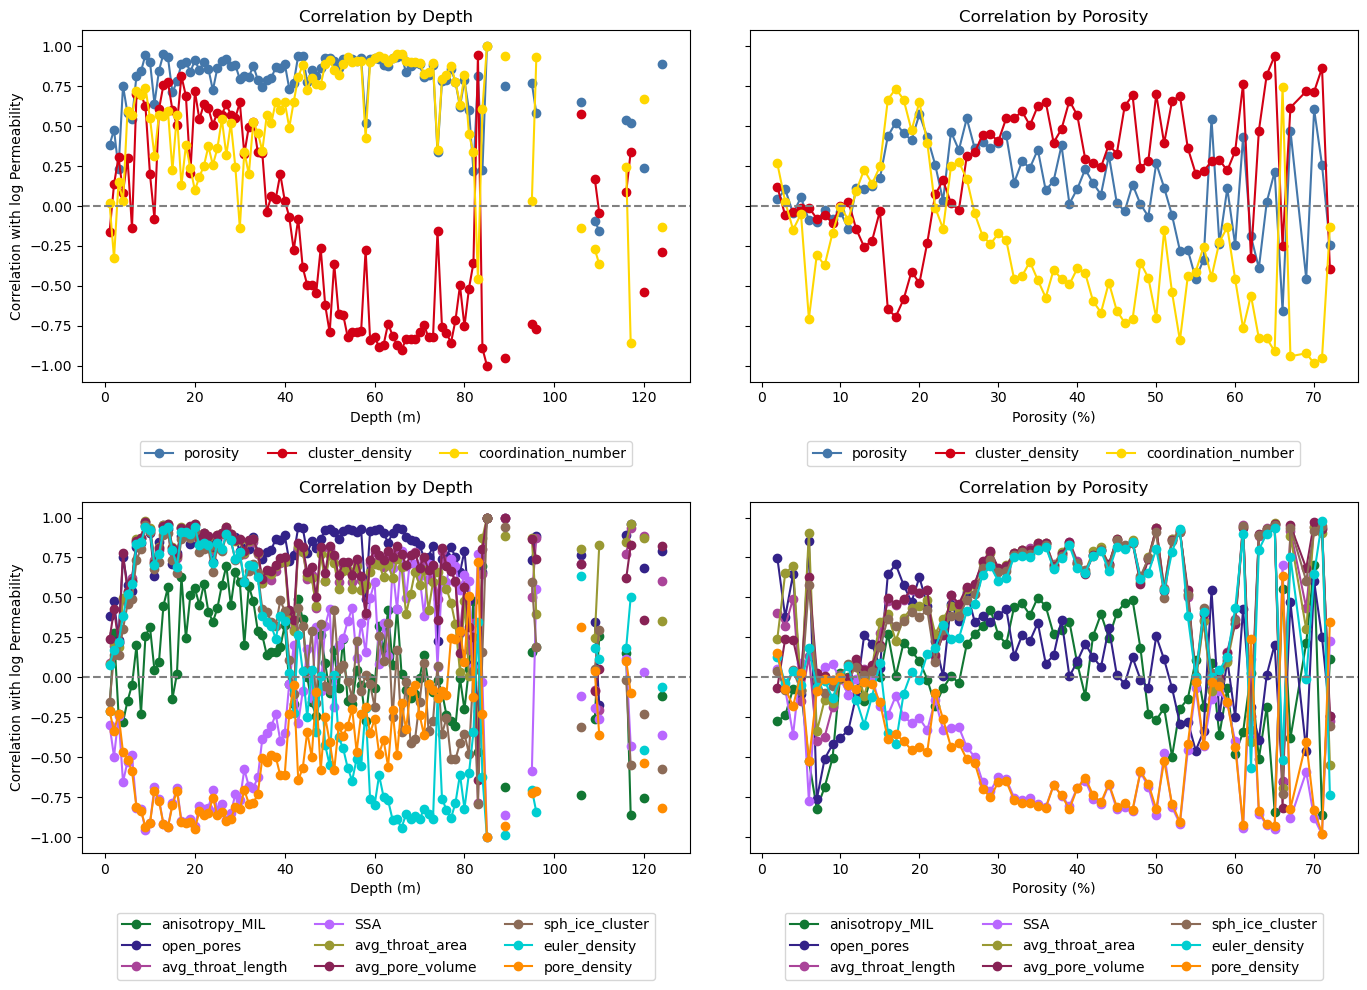

In [38]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)

# First 3 features - Depth
for feature in features_interest[:3]:
    axes[0, 0].plot(df_corr_depth['Depth_bin'], df_corr_depth[feature],
                    marker='o', label=feature, color=colors[feature])
axes[0, 0].set_xlabel('Depth (m)')
axes[0, 0].axhline(y=0, linestyle='--', color='gray')
axes[0, 0].set_ylabel('Correlation with log Permeability')
axes[0, 0].set_title('Correlation by Depth')
axes[0, 0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

# First 3 features - Porosity
for feature in features_interest[:3]:
    axes[0, 1].plot(df_corr_porosity['porosity_bin'], df_corr_porosity[feature],
                    marker='o', label=feature, color=colors[feature])
axes[0, 1].set_xlabel('Porosity (%)')
axes[0, 1].axhline(y=0, linestyle='--', color='gray')
axes[0, 1].set_title('Correlation by Porosity')
axes[0, 1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

# Remaining features - Depth
for feature in features_interest[3:]:
    axes[1, 0].plot(df_corr_depth['Depth_bin'], df_corr_depth[feature],
                    marker='o', label=feature, color=colors[feature])
axes[1, 0].set_xlabel('Depth (m)')
axes[1, 0].axhline(y=0, linestyle='--', color='gray')
axes[1, 0].set_ylabel('Correlation with log Permeability')
axes[1, 0].set_title('Correlation by Depth')
axes[1, 0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

# Remaining features - Porosity
for feature in features_interest[3:]:
    axes[1, 1].plot(df_corr_porosity['porosity_bin'], df_corr_porosity[feature],
                    marker='o', label=feature, color=colors[feature])
axes[1, 1].set_xlabel('Porosity (%)')
axes[1, 1].axhline(y=0, linestyle='--', color='gray')
axes[1, 1].set_title('Correlation by Porosity')
axes[1, 1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

plt.tight_layout()
plt.show()


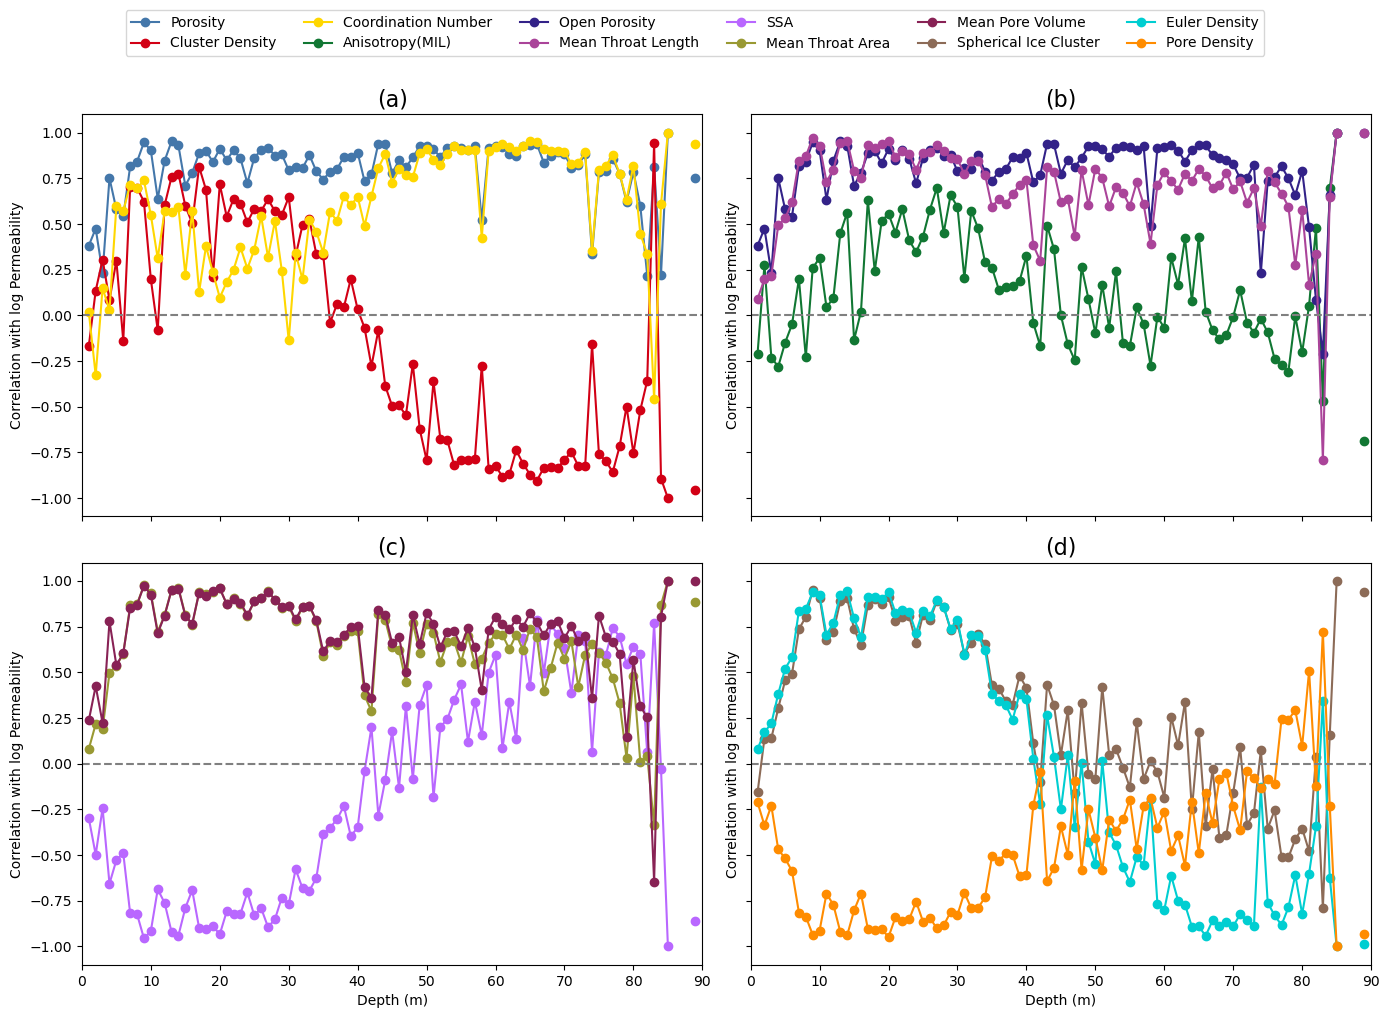

In [39]:
import matplotlib.pyplot as plt

# Create 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
axes = axes.flatten()

# Create a dictionary to map feature -> label
feature_to_label = dict(zip(features_interest, features_labels))

# Panel labels
panel_labels = ["(a)", "(b)", "(c)", "(d)"]

# Loop over 4 groups of 3 features each
for i in range(4):
    group = features_interest[i*3:(i+1)*3]  # take 3 features

    for feature in group:
        axes[i].plot(df_corr_depth['Depth_bin'], df_corr_depth[feature],
                     marker='o', label=feature_to_label[feature], color=colors[feature])

    axes[i].set_ylabel('Correlation with log Permeability')
    axes[i].axhline(y=0, linestyle='--', color='gray')

    # Add panel label
    axes[i].set_title(panel_labels[i], loc='center', fontsize=16)
    axes[i].set_xlim(0,90)

# Set x-axis label only for bottom row
for ax in axes[-2:]:
    ax.set_xlabel('Depth (m)')

# Collect handles and labels from all subplots
handles, labels = [], []
for ax in axes:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Ensure unique labels (in order of features_interest)
unique = dict(zip(features_labels, handles))  # preserves last handle but order by features_labels
ordered_handles = [unique[label] for label in features_labels]

# Apply tight layout first
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave extra top space

# Now add one legend above all subplots
fig.legend(ordered_handles, features_labels,
           loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.02))

plt.savefig('Corr_per_depth.png', dpi=400, bbox_inches="tight")
plt.show()


In [40]:
# Bin depth into 1m intervals

df = data.sort_values(by="new_depth").copy()


df = df[df['Perm_z'] > 0]
# Features of interest
features_interest = ['coordination_number', 'cluster_density','anisotropy_MIL', 'SSA','pore_density','throat_density']

df_corr_depth_log_perm = pd.DataFrame(columns=features_interest)
bin_size = 1  # meters per bin
df['Depth_bin'] = (df['new_depth'] // bin_size) * bin_size

df_corr_depth_log_perm['Depth_bin'] = np.array([i+1 for i in range(int(df['Depth_bin'].max()))])
                                 
for feature in features_interest:
    for depth, group in df.groupby('Depth_bin'):
        if len(group) > 1:  # need at least 2 points to compute correlation
            r = group['log_perm_z'].corr(group[feature])
            df_corr_depth_log_perm.loc[df_corr_depth_log_perm['Depth_bin'] == depth, feature] = r

In [41]:
df_corr_depth

porosity cluster_density coordination_number anisotropy_MIL open_pores  \
0    0.381847       -0.167014            0.018514      -0.209019   0.381961   
1    0.474824        0.134979            -0.32775       0.275482   0.474864   
2    0.232554        0.305414            0.149567      -0.230587   0.232511   
3     0.75087        0.083051            0.028966       -0.28036   0.751139   
4    0.579943        0.299631            0.596516      -0.149384   0.579949   
..        ...             ...                 ...            ...        ...   
125       NaN             NaN                 NaN            NaN        NaN   
126       NaN             NaN                 NaN            NaN        NaN   
127       NaN             NaN                 NaN            NaN        NaN   
128       NaN             NaN                 NaN            NaN        NaN   
129       NaN             NaN                 NaN            NaN        NaN   

    avg_throat_length       SSA avg_throat_area avg_pore_volume  \
0            0.090962 -0.298244        0.080418        0.237034   
1            0.196728 -0.497962        0.216785        0.424116   
2            0.217438 -0.243474        0.187902         0.22354   
3            0.492584  -0.65655        0.497189        0.778439   
4            0.530825 -0.527594        0.535016        0.539134   
..                ...       ...             ...             ...   
125               NaN       NaN             NaN             NaN   
126               NaN       NaN             NaN             NaN   
127               NaN       NaN             NaN             NaN   
128               NaN       NaN             NaN             NaN   
129               NaN       NaN             NaN             NaN   

    sph_ice_cluster euler_density pore_density  Depth_bin  
0         -0.157423      0.079674    -0.211607          1  
1          0.137725      0.173005    -0.337622          2  
2           0.13847      0.219937    -0.229893          3  
3           0.30283      0.381916    -0.469066          4  
4          0.455822      0.519979    -0.518655          5  
..              ...           ...          ...        ...  
125             NaN           NaN          NaN        126  
126             NaN           NaN          NaN        127  
127             NaN           NaN          NaN        128  
128             NaN           NaN          NaN        129  
129             NaN           NaN          NaN        130  

[130 rows x 13 columns]

# Permeability and Tortuosity feature correlation

In [100]:
df_fit = data[data["new_depth"]<80].copy()

df_fit = df_fit.drop(columns = ['name', 'number_of_regions', 'starting_layer', 'ending_layer','depth','sample_volume',
                               'num_pores','num_throats'])

df_fit = df_fit.drop(columns = ['MIL_y','MIL_x','Tort_x','Tort_y','Perm_x','Perm_y','num_cluster',
                                'max_connections','max_cluster_size','anisotropy_Perm','anisotropy_Tort'
                               ,'avg_throat_diameter','avg_pore_diameter'])

df_fit = df_fit[df_fit["Perm_z"] > 5e-14]
df_fit = df_fit[df_fit["Perm_z"] < 5e-6]

df_fit = df_fit[df_fit["Tort_z"] > 1]
df_fit = df_fit[df_fit["Tort_z"] < 500]



In [101]:
print('old column names = ',df_fit.columns)

old column names =  Index(['porosity', 'open_pores', 'cuted_pores', 'isolated_pores',
       'euler_density', 'SSA', 'MIL_z', 'Perm_z', 'Tort_z', 'sph_ice_cluster',
       'coordination_number', 'std_coordination_number', 'avg_pore_volume',
       'avg_throat_length', 'median_connections', 'avg_cluster_size',
       'avg_pore_surface_area', 'avg_throat_area', 'new_depth',
       'cluster_density', 'pore_density', 'throat_density', 'anisotropy_MIL',
       'density', 'D_eff__by__D_air', 'log_perm_z', 'log_log_perm_z'],
      dtype='object')


In [102]:
# Compute the correlation matrix
rename_map = {
'porosity':'Porosity',
'open_pores':'Open Porosity',
'cuted_pores':'Cuted Porosity',
'isolated_pores':'Isolated Porosity',
'euler_density':'Euler Density',
'SSA':'SSA',
'MIL_z':'MIL',
'Perm_z':'Permeability',
'Tort_z':'Tortuosity',
'sph_ice_cluster':'Spherical Ice Cluster',
'coordination_number':'Coordination Num',
'std_coordination_number':'SD Coordination Num', 
'avg_pore_volume':'Mean Pore Volume',
'avg_throat_length':'Mean Throat Length',
'median_connections':'Median Num Connections', 
'avg_cluster_size':'Mean Cluster Size',
'avg_pore_surface_area':'Mean Pore Surface Area',
'avg_throat_area':'Mean Throat Area',
'new_depth':'Depth',
'cluster_density':'Cluster Density', 
'pore_density':'Pore Density',
'throat_density':'Throat Density',
'anisotropy_MIL':'Anisotropy MIL',
'density':'Density',
'D_eff__by__D_air':'Normalized Diffusivity',
'log_perm_z':'log Permeability',
'log_log_perm_z':'log log Permeability'
}

df_fit = df_fit.rename(columns=rename_map)

corr_matrix = df_fit.corr()
corr_matrix

Porosity  Open Porosity  Cuted Porosity  \
Porosity                1.000000       0.997060       -0.519603   
Open Porosity           0.997060       1.000000       -0.583228   
Cuted Porosity         -0.519603      -0.583228        1.000000   
Isolated Porosity      -0.510926      -0.574645        0.978997   
Euler Density          -0.776492      -0.788217        0.558336   
SSA                     0.895458       0.906359       -0.615500   
MIL                    -0.923481      -0.943265        0.729324   
Permeability            0.140443       0.135639       -0.023978   
Tortuosity             -0.391582      -0.452133        0.879448   
Spherical Ice Cluster  -0.949771      -0.957168        0.607279   
Coordination Num        0.995787       0.995583       -0.547336   
SD Coordination Num     0.995728       0.991265       -0.500876   
Mean Pore Volume        0.799340       0.802860       -0.479826   
Mean Throat Length      0.705878       0.722905       -0.577724   
Median Num Connections  0.967142       0.965767       -0.518710   
Mean Cluster Size       0.796593       0.792257       -0.391482   
Mean Pore Surface Area  0.719179       0.731862       -0.536604   
Mean Throat Area        0.792521       0.794604       -0.460566   
Depth                  -0.968524      -0.974478        0.601722   
Cluster Density        -0.694483      -0.743666        0.922391   
Pore Density            0.733681       0.731470       -0.381175   
Throat Density          0.868668       0.861508       -0.399977   
Anisotropy MIL          0.723065       0.710690       -0.261862   
Density                -1.000000      -0.997060        0.519603   
Normalized Diffusivity  0.969608       0.957350       -0.399442   
log Permeability        0.884829       0.913374       -0.801223   
log log Permeability         NaN            NaN             NaN   

                        Isolated Porosity  Euler Density       SSA       MIL  \
Porosity                        -0.510926      -0.776492  0.895458 -0.923481   
Open Porosity                   -0.574645      -0.788217  0.906359 -0.943265   
Cuted Porosity                   0.978997       0.558336 -0.615500  0.729324   
Isolated Porosity                1.000000       0.553053 -0.607725  0.721954   
Euler Density                    0.553053       1.000000 -0.962481  0.871846   
SSA                             -0.607725      -0.962481  1.000000 -0.958044   
MIL                              0.721954       0.871846 -0.958044  1.000000   
Permeability                    -0.023434      -0.035576  0.029434 -0.075840   
Tortuosity                       0.897807       0.420576 -0.466122  0.564272   
Spherical Ice Cluster            0.597398       0.898401 -0.976190  0.967382   
Coordination Num                -0.539457      -0.815682  0.926013 -0.941948   
SD Coordination Num             -0.490933      -0.739955  0.868986 -0.907530   
Mean Pore Volume                -0.474549      -0.395597  0.558665 -0.723776   
Mean Throat Length              -0.574272      -0.364731  0.522370 -0.710753   
Median Num Connections          -0.510629      -0.806661  0.910848 -0.921107   
Mean Cluster Size               -0.385286      -0.793655  0.821882 -0.742895   
Mean Pore Surface Area          -0.533624      -0.369909  0.527987 -0.706795   
Mean Throat Area                -0.454235      -0.389342  0.556805 -0.713781   
Depth                            0.591399       0.855651 -0.951507  0.973189   
Cluster Density                  0.933591       0.728409 -0.790055  0.881603   
Pore Density                    -0.373425      -0.899059  0.870005 -0.730838   
Throat Density                  -0.393040      -0.864943  0.891650 -0.798344   
Anisotropy MIL                  -0.255727      -0.501516  0.634355 -0.611185   
Density                          0.510926       0.776492 -0.895458  0.923481   
Normalized Diffusivity          -0.390908      -0.665540  0.805984 -0.827767   
log Permeability                -0.803931      -0.774402  0.873745 

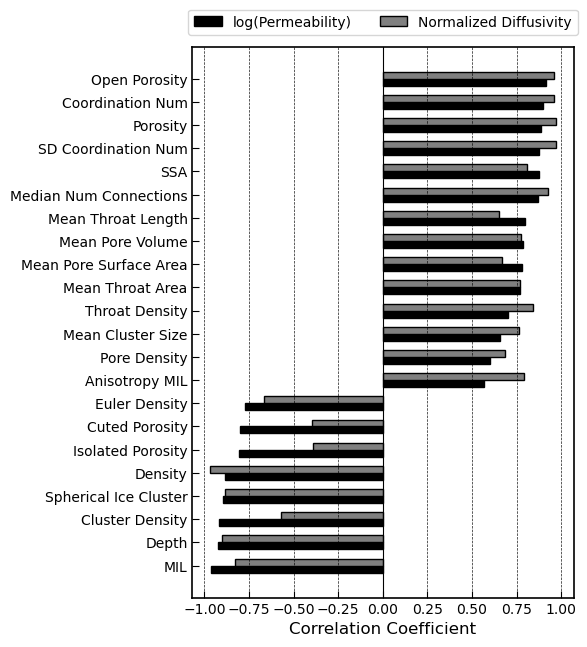

In [103]:
# Get correlations for Perm_z and Tort_z (excluding self-correlations)
features = corr_matrix.columns.drop(['Permeability', 'Tortuosity', 'Normalized Diffusivity','log log Permeability','log Permeability'])
perm_corr = corr_matrix.loc[features,'log Permeability']
tort_corr = corr_matrix.loc[features, 'Normalized Diffusivity']

features_sorted = perm_corr.sort_values().index
perm_sorted = perm_corr[features_sorted]
tort_sorted = tort_corr[features_sorted]


# Plotting
fig, ax = plt.subplots(figsize=(6, len(features_sorted) * 0.3))  # Portrait layout

bar_width = 0.3
indices = np.arange(len(features_sorted))

# Colorblind-safe colors
perm_color = 'black'   # Blue
tort_color = 'gray'   # Orange

# Horizontal bars
ax.barh(indices - bar_width/2, perm_sorted, height=bar_width, color=perm_color, edgecolor='black', label='log(Permeability)')
ax.barh(indices + bar_width/2, tort_sorted, height=bar_width, color=tort_color, edgecolor='black', label='Normalized Diffusivity')

# Labels and aesthetics
ax.set_yticks(indices)
ax.set_yticklabels(features_sorted, fontsize=10,color='black')
ax.set_xlabel('Correlation Coefficient', fontsize=12)
#ax.set_title('Correlation of Features with Perm_z and Tort_z', fontsize=13)

# Gridlines and axis styling
ax.grid(axis='x', linestyle='--', color='black', linewidth=0.5, alpha=0.9)
ax.axvline(0, color='black', linewidth=0.8)
ax.tick_params(axis='x', labelsize=10)

# Legend
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=2, frameon=True, fontsize=10)
plt.tight_layout()
#plt.savefig('correlation_perm_tort.png',dpi=300)
plt.show()

In [104]:
df_fit.columns

Index(['Porosity', 'Open Porosity', 'Cuted Porosity', 'Isolated Porosity',
       'Euler Density', 'SSA', 'MIL', 'Permeability', 'Tortuosity',
       'Spherical Ice Cluster', 'Coordination Num', 'SD Coordination Num',
       'Mean Pore Volume', 'Mean Throat Length', 'Median Num Connections',
       'Mean Cluster Size', 'Mean Pore Surface Area', 'Mean Throat Area',
       'Depth', 'Cluster Density', 'Pore Density', 'Throat Density',
       'Anisotropy MIL', 'Density', 'Normalized Diffusivity',
       'log Permeability', 'log log Permeability'],
      dtype='object')

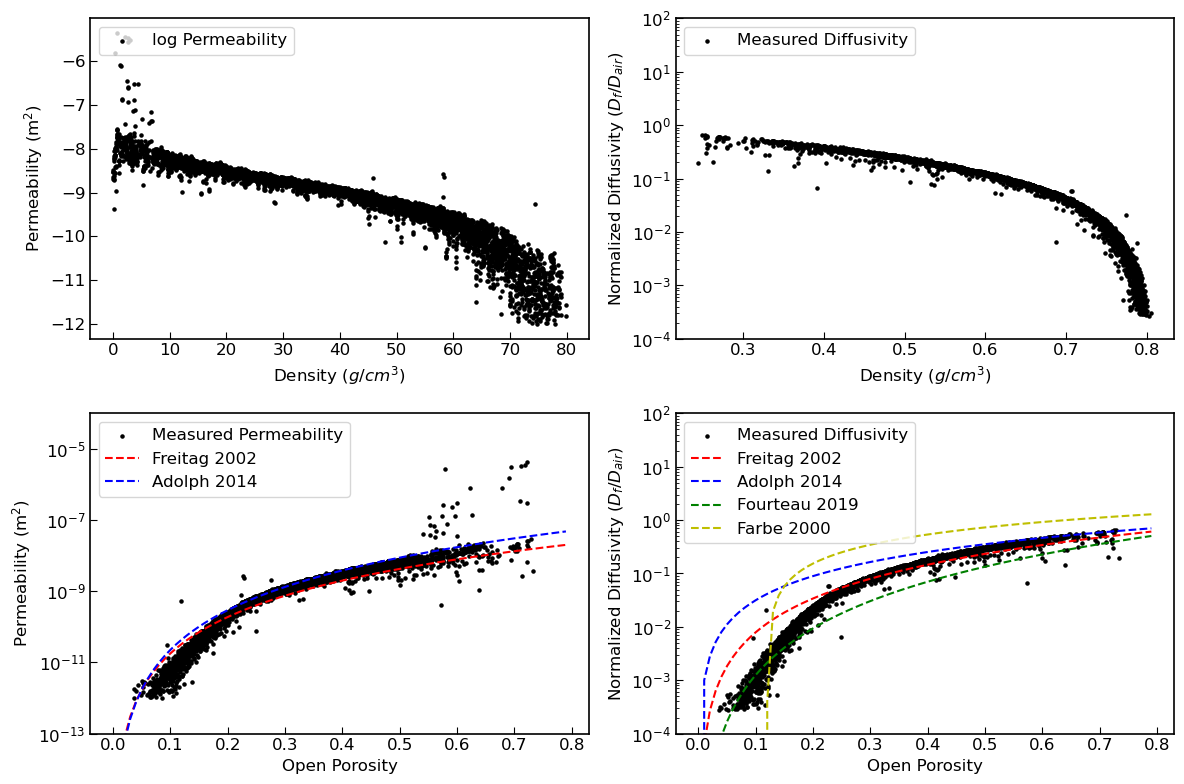

In [106]:

df = df_fit.copy()

x = df_fit['Porosity']/100     
y1 = df_fit['log Permeability'] # First y-axis data
y2 = df_fit['Normalized Diffusivity']       # Second y-axis data

pr = np.array(list(range(80)))/100 #for drawing line in open porosity

# Define models
def freitag_perm_model(p): return 10**-7.7 * (1.5**2) * p**3.4
def adolph_perm_model(p): return 10**-7.29 * (1.5**2) * p**3.71

#m=1.5
freitag_perm =  freitag_perm_model(pr)
adolph_perm = adolph_perm_model(pr)

freitag_def =  pr**2.1
adolph_def= pr**1.5
fourteau_def= pr**2.9
farbe_def = 1.92*pr-0.23

freitag_diffusivity = pr**2.9
freitag_diffusivity = 1.7*(df_fit['Open Porosity']/100) -0.2

# Apply academic-style formatting
plt.rcParams.update({
    "font.size": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5
})

s1 = 5  # marker size

# Create one figure with two subplots side-by-side
fig, ((ax1, ax2), (ax3 , ax4)) = plt.subplots(2, 2, figsize=(12, 8))

# — Plot 1: Permeability —
ax1.scatter(df_fit['Depth'], y1, label='log Permeability', color='black', s=s1)
#ax1.scatter(df_fit['Open Porosity']/100, y1, label='log Permeability', color='black', s=s1)

ax1.set_xlabel('Density ($g/cm^{3}$)')
ax1.set_ylabel(r'Permeability ($\mathrm{m}^2$)', color='black')
#ax1.set_yscale('log')
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')
#ax1.set_title('Permeability')
#ax1.set_ylim(10e-14,10e-5)

# — Plot 2: Diffusivity —
ax2.scatter(df_fit['Density'], y2, label='Measured Diffusivity', color='black', s=s1)
#ax2.plot(x, freitag_diffusivity, '--', label='Freitag 2002', color='r')

ax2.set_xlabel('Density ($g/cm^{3}$)')
ax2.set_ylabel(r'Normalized Diffusivity ($D_f/D_{air}$)', color='black')
ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor='black')
ax2.legend(loc='upper left')
#ax2.set_title('Diffusivity vs. Porosity')
ax2.set_ylim(1e-4,10e1)


y1 = df_fit['Permeability']

# — Plot 3: Permeability —
ax3.scatter(df_fit['Open Porosity']/100, y1, label='Measured Permeability', color='black', s=s1)
ax3.plot(pr, freitag_perm, '--', label='Freitag 2002', color='r')
ax3.plot(pr, adolph_perm, '--', label='Adolph 2014', color='b')

ax3.set_xlabel('Open Porosity')
ax3.set_ylabel(r'Permeability ($\mathrm{m}^2$)', color='black')
ax3.set_yscale('log')
ax3.tick_params(axis='y', labelcolor='black')
ax3.legend(loc='upper left')
#ax1.set_title('Permeability')
ax3.set_ylim(10e-14,10e-5)

# — Plot 4: Diffusivity —
ax4.scatter(df_fit['Open Porosity']/100, y2, label='Measured Diffusivity', color='black', s=s1)
ax4.plot(pr, freitag_def, '--', label='Freitag 2002', color='r')
ax4.plot(pr, adolph_def, '--', label='Adolph 2014', color='b')
ax4.plot(pr, fourteau_def, '--', label='Fourteau 2019', color='g')
ax4.plot(pr, farbe_def, '--', label='Farbe 2000', color='y')

ax4.set_xlabel('Open Porosity')
ax4.set_ylabel(r'Normalized Diffusivity ($D_f/D_{air}$)', color='black')
ax4.set_yscale('log')
ax4.tick_params(axis='y', labelcolor='black')
ax4.legend(loc='upper left')
#ax2.set_title('Diffusivity vs. Porosity')
ax4.set_ylim(1e-4,10e1)




plt.tight_layout()
#plt.savefig("perm_defus_open_porosity.png", dpi=400, bbox_inches='tight')
plt.show()

In [24]:
from sklearn.metrics import r2_score, mean_squared_error


In [25]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Extract open porosity
df_fit = df_fit[df_fit['Open Porosity']>0]
porosity_open = df_fit['Open Porosity'] / 100

# -------------------------
# Interpolate model values to measurement points
# -------------------------

# Define models
def freitag_perm_model(p): return 10**-7.7 * (1.5**2) * p**3.4
def adolph_perm_model(p): return 10**-7.29 * (1.5**2) * p**3.71

def freitag_def_model(p): return p**2.1
def adolph_def_model(p): return p**1.5
def fourteau_def_model(p): return p**2.9
def farbe_def_model(p): return 1.92 * p - 0.23

# Compute model values at same porosity as data
freitag_perm_pred = freitag_perm_model(porosity_open)
adolph_perm_pred = adolph_perm_model(porosity_open)

freitag_def_pred = freitag_def_model(porosity_open)
adolph_def_pred = adolph_def_model(porosity_open)
fourteau_def_pred = fourteau_def_model(porosity_open)
farbe_def_pred = farbe_def_model(porosity_open)

# True values
y_perm_true = df_fit['Permeability'].values
y_def_true = df_fit['Normalized Diffusivity'].values

# -------------------------
# Metrics
# -------------------------
def print_log_metrics(name, y_true, y_pred):
    mask = (y_true > 0) & (y_pred > 0)
    y_true_log = np.log10(y_true[mask])
    y_pred_log = np.log10(y_pred[mask])
    r2 = r2_score(y_true_log, y_pred_log)
    rmse = np.sqrt(mean_squared_error(y_true_log, y_pred_log))
    print(f"{name} (log-scale):\n  R² = {r2:.4f}\n  RMSE = {rmse:.4f} (log10 units)")
    

print("=== Permeability Models ===")
print_log_metrics("Freitag 2002", y_perm_true, freitag_perm_pred)
print_log_metrics("Adolph 2014", y_perm_true, adolph_perm_pred)

print("\n=== Diffusivity Models ===")
print_log_metrics("Freitag 2002", y_def_true, freitag_def_pred)
print_log_metrics("Adolph 2014", y_def_true, adolph_def_pred)
print_log_metrics("Fourteau 2019", y_def_true, fourteau_def_pred)
print_log_metrics("Farbe 2000", y_def_true, farbe_def_pred)


=== Permeability Models ===
Freitag 2002 (log-scale):
  R² = 0.9065
  RMSE = 0.2692 (log10 units)
Adolph 2014 (log-scale):
  R² = 0.9133
  RMSE = 0.2593 (log10 units)

=== Diffusivity Models ===
Freitag 2002 (log-scale):
  R² = 0.8085
  RMSE = 0.2983 (log10 units)
Adolph 2014 (log-scale):
  R² = 0.2394
  RMSE = 0.5945 (log10 units)
Fourteau 2019 (log-scale):
  R² = 0.6976
  RMSE = 0.3748 (log10 units)
Farbe 2000 (log-scale):
  R² = -0.4964
  RMSE = 0.6691 (log10 units)


In [26]:
df_fit['log log Permeability']

706    NaN
707    NaN
708    NaN
709    NaN
710    NaN
        ..
9092   NaN
9093   NaN
9094   NaN
9095   NaN
9096   NaN
Name: log log Permeability, Length: 5419, dtype: float64

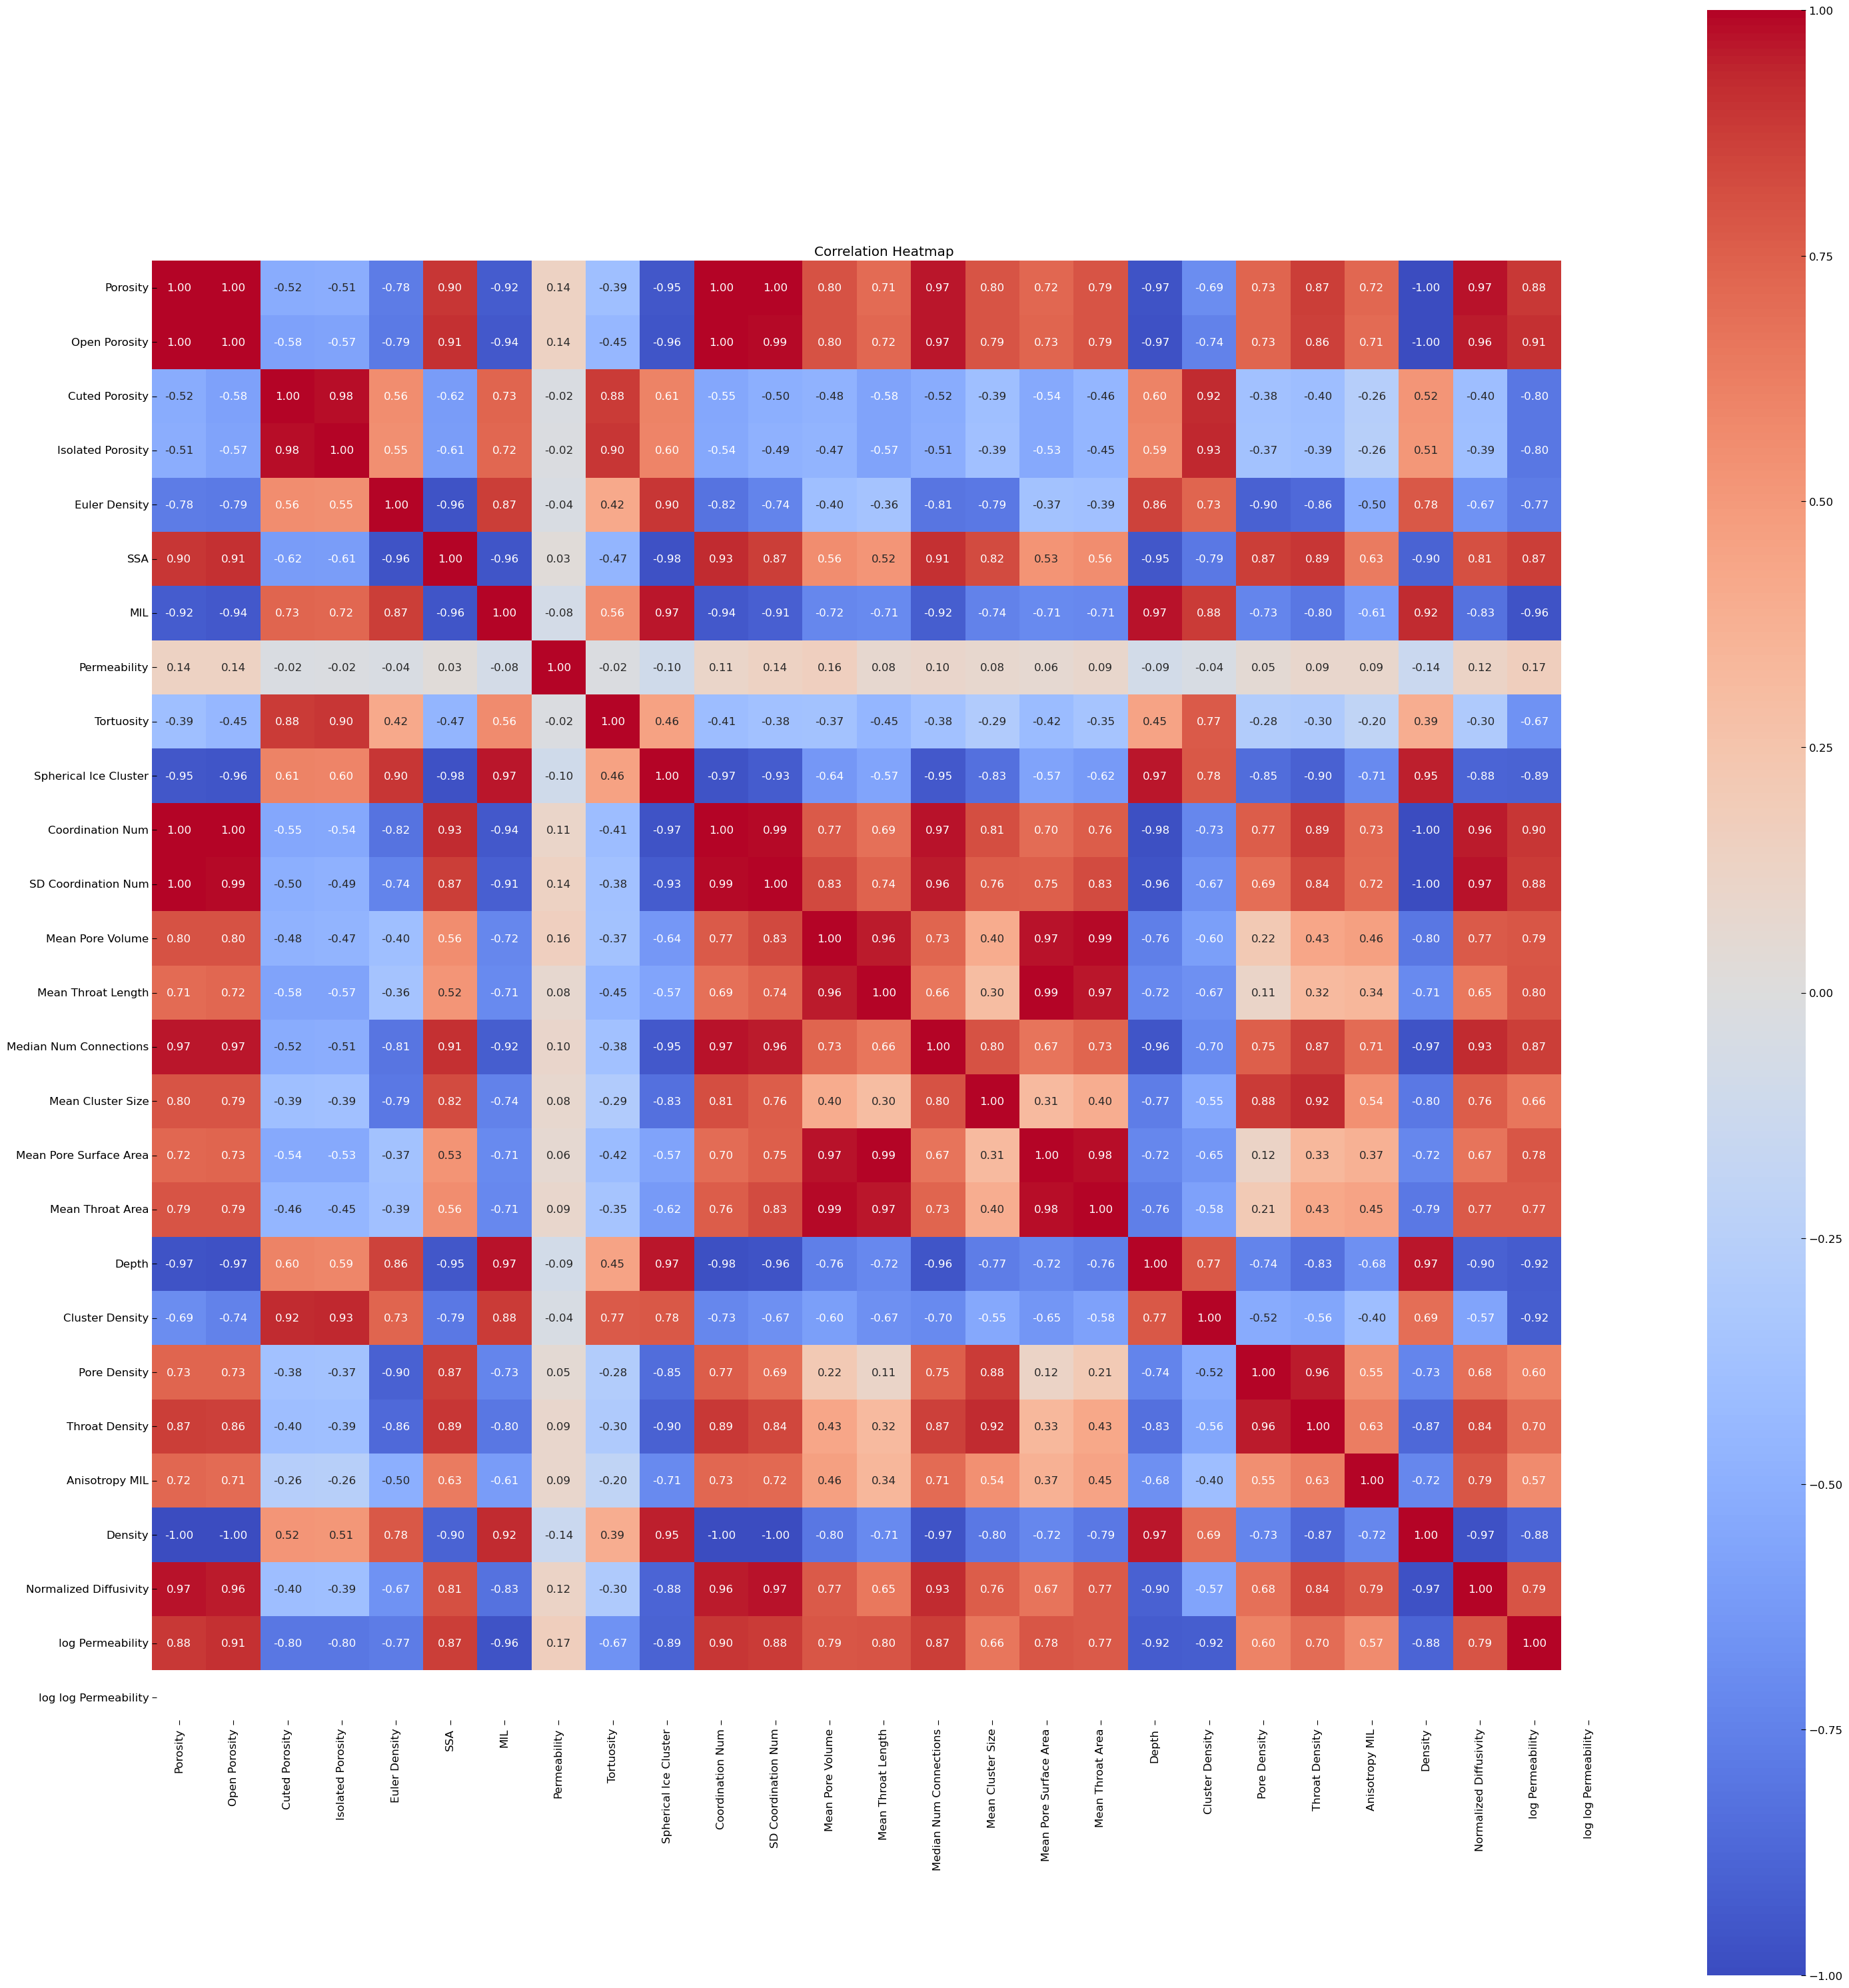

In [27]:


# Set up the matplotlib figure
plt.figure(figsize=(30, 30))

# Draw the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)

# Show the plot
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.savefig('correlation_1_60.png')

In [107]:
# Load dataset
df = data.copy()

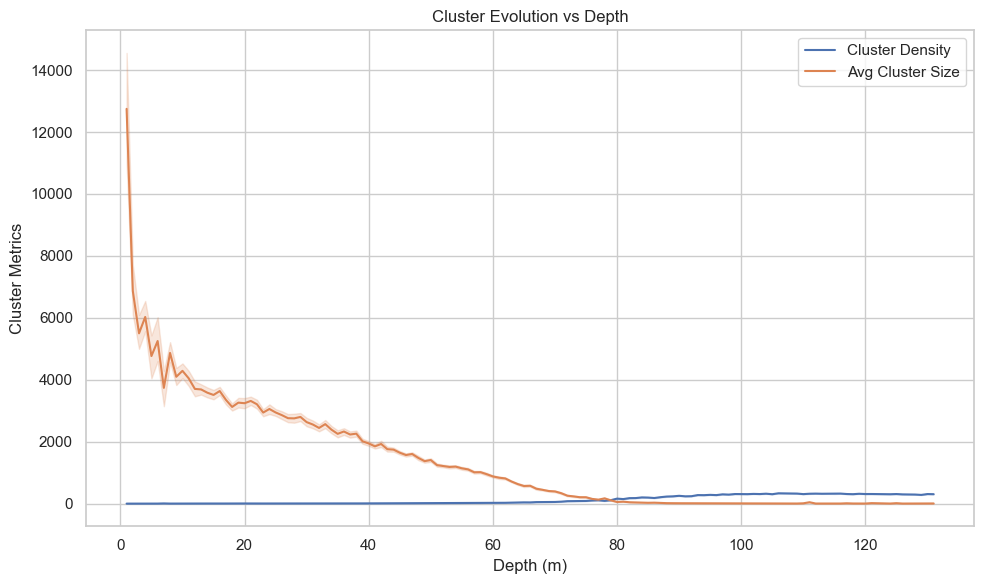

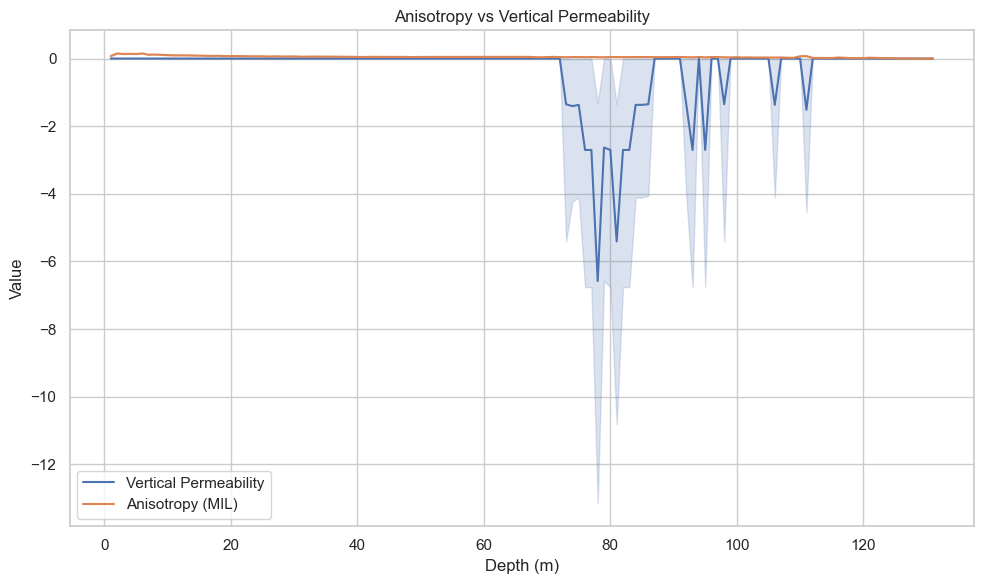

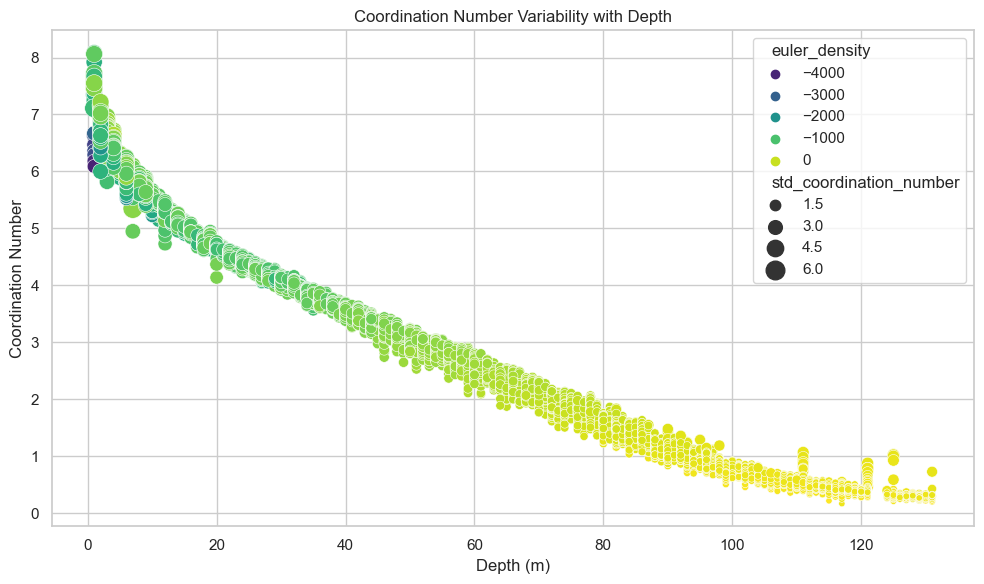

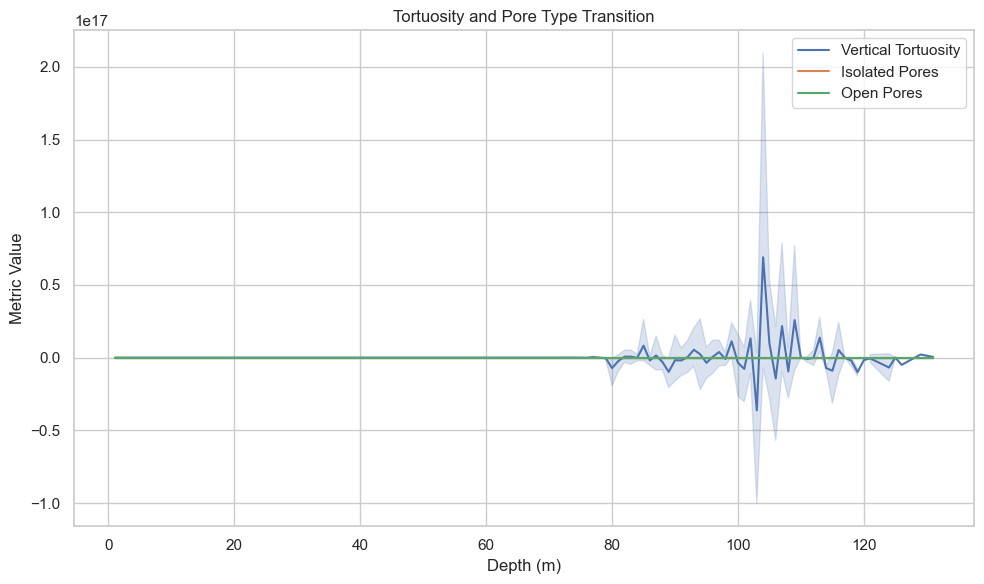

C:\Users\Faramarz\AppData\Local\Temp\ipykernel_7012\889039487.py:55: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  averaged = df.groupby(pd.cut(df['depth'], bins=depth_bins)).mean()


In [29]:

import plotly.express as px



# Set seaborn theme
sns.set(style="whitegrid")

# HYPOTHESIS 1: Cluster-Based Densification Dynamics
plt.figure(figsize=(10, 6))
sns.lineplot(x="depth", y="cluster_density", label="Cluster Density", data=df)
sns.lineplot(x="depth", y="avg_cluster_size", label="Avg Cluster Size", data=df)
plt.title("Cluster Evolution vs Depth")
plt.xlabel("Depth (m)")
plt.ylabel("Cluster Metrics")
plt.legend()
plt.tight_layout()
plt.show()

# HYPOTHESIS 2: Anisotropy-Controlled Permeability Evolution
plt.figure(figsize=(10, 6))
sns.lineplot(x="depth", y="Perm_z", label="Vertical Permeability", data=df)
sns.lineplot(x="depth", y="anisotropy_MIL", label="Anisotropy (MIL)", data=df)
plt.title("Anisotropy vs Vertical Permeability")
plt.xlabel("Depth (m)")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

# HYPOTHESIS 3: Coordination Number and Collapse Indicators
plt.figure(figsize=(10, 6))
sns.scatterplot(x="depth", y="coordination_number", size="std_coordination_number", hue="euler_density", data=df, palette="viridis", sizes=(20, 200))
plt.title("Coordination Number Variability with Depth")
plt.xlabel("Depth (m)")
plt.ylabel("Coordination Number")
plt.tight_layout()
plt.show()

# HYPOTHESIS 4: Tortuosity vs Pore Isolation
plt.figure(figsize=(10, 6))
sns.lineplot(x="depth", y="Tort_z", label="Vertical Tortuosity", data=df)
sns.lineplot(x="depth", y="isolated_pores", label="Isolated Pores", data=df)
sns.lineplot(x="depth", y="open_pores", label="Open Pores", data=df)
plt.title("Tortuosity and Pore Type Transition")
plt.xlabel("Depth (m)")
plt.ylabel("Metric Value")
plt.legend()
plt.tight_layout()
plt.show()

# HYPOTHESIS 5: Multivariate Fingerprinting (PCA-style proxy with radar plot)
import plotly.graph_objects as go

def radar_plot(df, depth_bins):
    averaged = df.groupby(pd.cut(df['depth'], bins=depth_bins)).mean()
    parameters = ['porosity', 'SSA', 'euler_density', 'avg_pore_surface_area', 'avg_pore_diameter', 'avg_throat_diameter']
    
    fig = go.Figure()
    for idx, row in averaged.iterrows():
        fig.add_trace(go.Scatterpolar(
            r=[row[p] for p in parameters],
            theta=parameters,
            fill='toself',
            name=f"{idx}"
        ))
    fig.update_layout(
        polar=dict(radialaxis=dict(visible=True)),
        title="Radar Plot of Microstructural Fingerprint by Depth Bin",
        showlegend=True
    )
    fig.show()

# Define depth bins and call radar plot
depth_bins = [0, 10, 20, 30, 40, 50]
radar_plot(df, depth_bins)


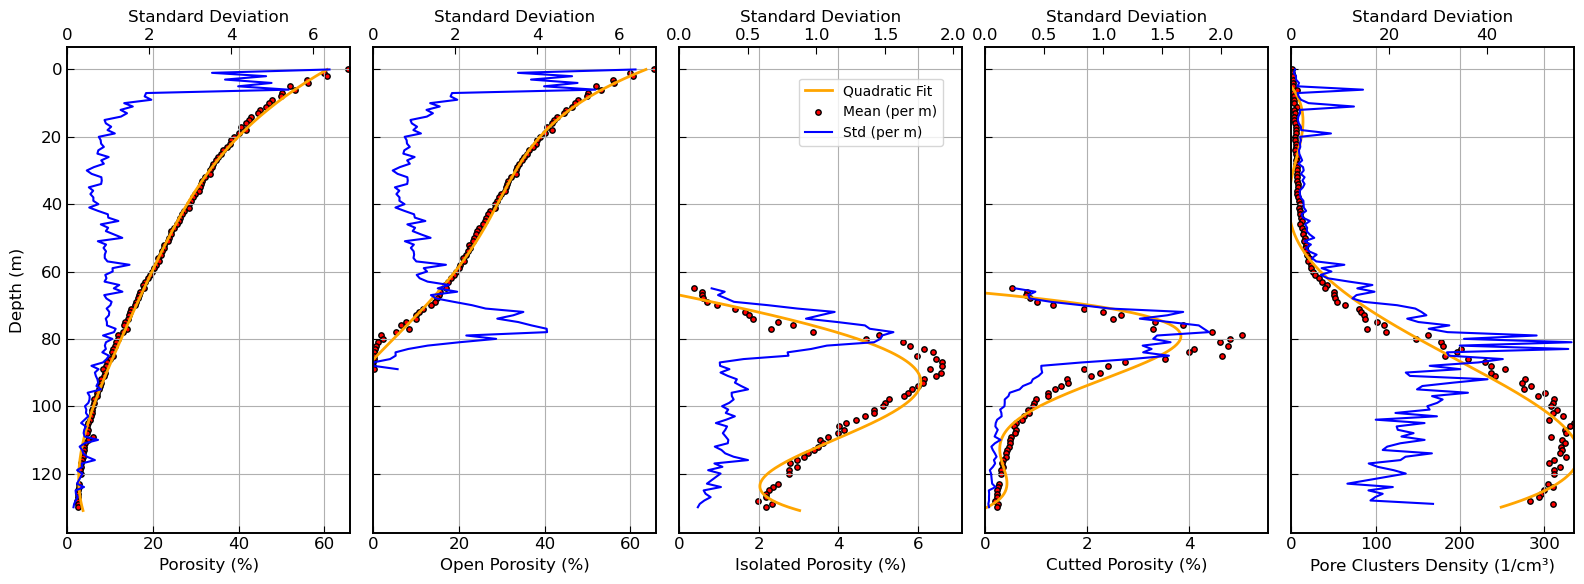

In [108]:
# Sort data by depth
df = data.sort_values(by="new_depth").copy()

# Create figure with shared y-axis
fig, axes = plt.subplots(1, 5, figsize=(16, 6), sharey=True)

# Academic-style formatting
plt.rcParams.update({
    "font.size": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5
})

# Plot configs
params = [
    ("porosity", "Porosity (%)"),
    ("open_pores", "Open Porosity (%)"),
    ("isolated_pores", "Isolated Porosity (%)"),
    ("cuted_pores", "Cutted Porosity (%)"),
    ('cluster_density','Pore Clusters Density (1/cm³)')
]

depth = df["new_depth"]

all_handles, all_labels = [], []

for ax, (col, xlabel) in zip(axes, params):
    # Subset based on column-specific depth ranges
    if col == "open_pores":
        df_fit = df[df["new_depth"] < 90].copy()
    elif col in ["isolated_pores", "cuted_pores"]:
        df_fit = df[df["new_depth"] > 65].copy()
    elif col == "cluster_density":
        df_fit = df[df["new_depth"] < 130].copy()
    else:
        df_fit = df.copy()
    
    y = df_fit["new_depth"]
    x = df_fit[col]
    df_fit["depth_bin"] = y.astype(int)
    grouped = df_fit.groupby("depth_bin")[col]

    mean_per_bin = grouped.mean()
    std_per_bin = grouped.std()
    depth_bins = mean_per_bin.index

    # Fit polynomial (degree 4)
    coeffs = np.polyfit(y, x, deg=4)
    poly = np.poly1d(coeffs)
    y_fit = np.linspace(y.min(), y.max(), 200)
    x_fit = poly(y_fit)

    # Main plot
    h1, = ax.plot(x_fit, y_fit, color='orange', linewidth=2, label='Quadratic Fit')
    h2 = ax.scatter(mean_per_bin, depth_bins, color='Red', edgecolors='black', s=15, label='Mean (per m)')

    # Std on top axis
    ax_top = ax.twiny()
    h3, = ax_top.plot(std_per_bin, depth_bins, color='Blue', linestyle='-', label='Std (per m)')
    ax_top.set_xlabel('Standard Deviation')
    ax_top.set_xlim(0,std_per_bin.max()+0.5)
    ax_top.grid(False)
    # Column-specific x-limits
    if col == 'isolated_pores' or col == 'cuted_pores':
        ax.set_xlim(0, 8)
    elif col == 'porosity':
        ax.set_xlim(0.1, 80)

    # Labels and grid
    ax.set_xlabel(xlabel)
    ax.set_xlim(0,mean_per_bin.max()+0.5)
    ax.grid(True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)

    # Collect handles for shared legend
    all_handles.extend([h1, h2, h3])
    all_labels.extend(['Quadratic Fit', 'Mean (per m)', 'Std (per m)'])

# Shared y-label and invert depth
axes[0].set_ylabel("Depth (m)")
axes[0].invert_yaxis()

# One global legend outside the plot
by_label = dict(zip(all_labels, all_handles))  # remove duplicates
fig.legend(by_label.values(), by_label.keys(),
           loc="center left", bbox_to_anchor=(0.5, 0.8),
           fontsize=10, frameon=True)

plt.tight_layout()
plt.savefig("fig_porosity.png", dpi=600, bbox_inches='tight')
plt.show()


In [48]:
df.columns

Index(['name', 'number_of_regions', 'starting_layer', 'ending_layer', 'depth',
       'sample_volume', 'porosity', 'open_pores', 'cuted_pores',
       'isolated_pores', 'euler_density', 'SSA', 'MIL_x', 'MIL_y', 'MIL_z',
       'Perm_x', 'Perm_y', 'Perm_z', 'Tort_x', 'Tort_y', 'Tort_z',
       'sph_ice_cluster', 'num_pores', 'num_throats', 'coordination_number',
       'std_coordination_number', 'avg_pore_volume', 'avg_pore_diameter',
       'avg_throat_diameter', 'avg_throat_length', 'max_connections',
       'median_connections', 'num_cluster', 'max_cluster_size',
       'avg_cluster_size', 'avg_pore_surface_area', 'avg_throat_area',
       'new_depth', 'cluster_density', 'pore_density', 'throat_density',
       'anisotropy_MIL', 'anisotropy_Perm', 'anisotropy_Tort', 'density',
       'D_eff__by__D_air', 'log_perm_z', 'log_log_perm_z'],
      dtype='object')

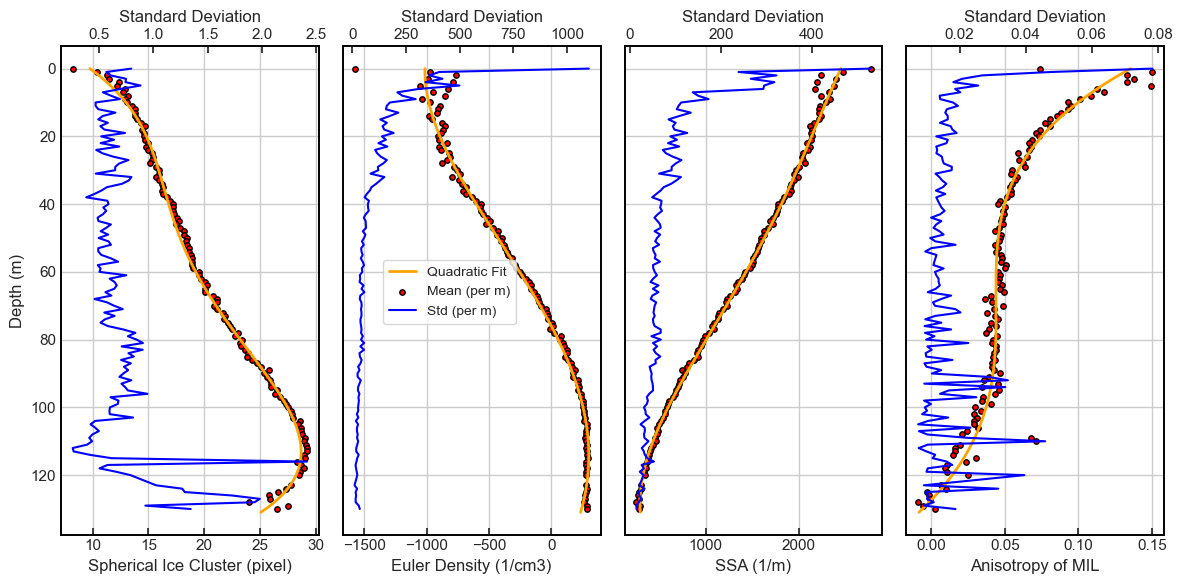

In [49]:
# Sort data by depth for smooth plotting
df = df.sort_values(by="new_depth")

# Create figure with shared y-axis
fig, axes = plt.subplots(1, 4, figsize=(12, 6), sharey=True)

# Apply academic-style formatting
plt.rcParams.update({
    "font.size": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5
})

# Plot configs
params = [
    ("sph_ice_cluster", "Spherical Ice Cluster (pixel)"),
    ("euler_density", "Euler Density (1/cm3)"),
    ("SSA", "SSA (1/m)"),
    ("anisotropy_MIL", "Anisotropy of MIL")
]

all_handles, all_labels = [], []

for ax, (col, xlabel) in zip(axes, params):
    x = df[col]
    y = df["new_depth"]

    df["depth_bin"] = df["new_depth"].astype(int)
    grouped = df.groupby("depth_bin")[col]

    mean_per_bin = grouped.mean()
    std_per_bin = grouped.std()
    depth_bins = mean_per_bin.index

    # Fit polynomial (degree 4)
    coeffs = np.polyfit(y, x, deg=4)
    poly = np.poly1d(coeffs)
    y_fit = np.linspace(y.min(), y.max(), 200)
    x_fit = poly(y_fit)

    # Main plot
    h1, = ax.plot(x_fit, y_fit, color='orange', linewidth=2, label='Quadratic Fit')
    h2 = ax.scatter(mean_per_bin, depth_bins, color='Red', edgecolors='black', s=15, label='Mean (per m)')

    # Std on top axis
    ax_top = ax.twiny()
    ax_top.grid(False)
    h3, = ax_top.plot(std_per_bin, depth_bins, color='Blue', label='Std (per m)')
    ax_top.set_xlabel('Standard Deviation')
    #ax_top.set_xlim(0,std_per_bin.max()+0.5)
    # Labels and grid
    ax.set_xlabel(xlabel)
    
    ax.grid(True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)

    # Collect handles and labels
    for h, l in zip([h1, h2, h3], ['Quadratic Fit', 'Mean (per m)', 'Std (per m)']):
        all_handles.append(h)
        all_labels.append(l)

# Shared y-label and inverted axis
axes[0].set_ylabel("Depth (m)")
axes[0].invert_yaxis()

# Make one global legend (unique labels only)
by_label = dict(zip(all_labels, all_handles))
fig.legend(by_label.values(), by_label.keys(),
           loc="center left", bbox_to_anchor=(0.32, 0.5),
           fontsize=10, frameon=True)

plt.tight_layout()
plt.savefig("fig_SIC_SSA_Euler.png", dpi=600, bbox_inches='tight')
plt.show()


In [50]:
df.columns

Index(['name', 'number_of_regions', 'starting_layer', 'ending_layer', 'depth',
       'sample_volume', 'porosity', 'open_pores', 'cuted_pores',
       'isolated_pores', 'euler_density', 'SSA', 'MIL_x', 'MIL_y', 'MIL_z',
       'Perm_x', 'Perm_y', 'Perm_z', 'Tort_x', 'Tort_y', 'Tort_z',
       'sph_ice_cluster', 'num_pores', 'num_throats', 'coordination_number',
       'std_coordination_number', 'avg_pore_volume', 'avg_pore_diameter',
       'avg_throat_diameter', 'avg_throat_length', 'max_connections',
       'median_connections', 'num_cluster', 'max_cluster_size',
       'avg_cluster_size', 'avg_pore_surface_area', 'avg_throat_area',
       'new_depth', 'cluster_density', 'pore_density', 'throat_density',
       'anisotropy_MIL', 'anisotropy_Perm', 'anisotropy_Tort', 'density',
       'D_eff__by__D_air', 'log_perm_z', 'log_log_perm_z', 'depth_bin'],
      dtype='object')

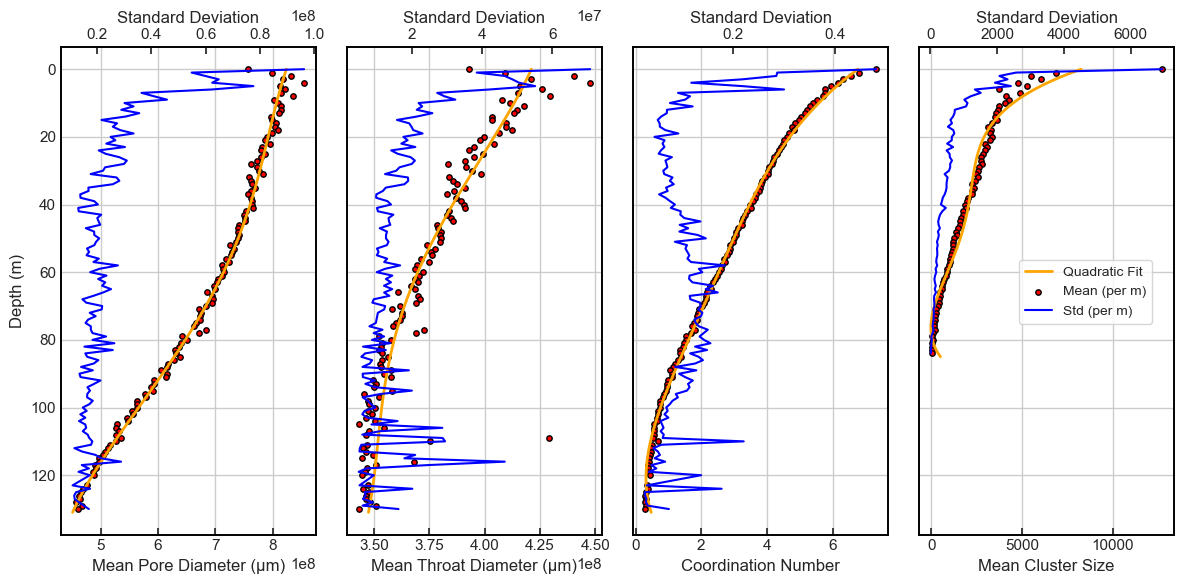

In [51]:
# Sort data by depth for smooth plotting
df = df.sort_values(by="new_depth")

# Create figure with shared y-axis
fig, axes = plt.subplots(1, 4, figsize=(12, 6), sharey=True)

# Apply academic-style formatting
plt.rcParams.update({
    "font.size": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5
})

# Plot configs
params = [
    ("avg_pore_diameter", "Mean Pore Diameter (μm)"),
    ("avg_throat_diameter", "Mean Throat Diameter (μm)"),
    ("coordination_number", "Coordination Number"),
    ("avg_cluster_size", "Mean Cluster Size")
]

all_handles, all_labels = [], []  # for one global legend

for ax, (col, xlabel) in zip(axes, params):

    if col == "avg_cluster_size":
        # Subset for depth < 85
        df_fit = df[df["new_depth"] < 85].copy()
        y = df_fit["new_depth"]
        x = df_fit[col]
        df_fit["depth_bin"] = df_fit["new_depth"].astype(int)
        grouped = df_fit.groupby("depth_bin")[col]
    else:
        y = df["new_depth"]
        x = df[col]
        df["depth_bin"] = df["new_depth"].astype(int)
        grouped = df.groupby("depth_bin")[col]

    mean_per_bin = grouped.mean()
    std_per_bin = grouped.std()
    depth_bins = mean_per_bin.index

    # Fit polynomial (degree 4)
    coeffs = np.polyfit(y, x, deg=4)
    poly = np.poly1d(coeffs)
    y_fit = np.linspace(y.min(), y.max(), 200)
    x_fit = poly(y_fit)

    # Main plot elements
    h1, = ax.plot(x_fit, y_fit, color='orange', linewidth=2, label='Quadratic Fit')
    h2 = ax.scatter(mean_per_bin, depth_bins, color='Red', edgecolors='black', s=15, label='Mean (per m)')

    # Std on top axis
    ax_top = ax.twiny()
    ax_top.grid(False)
    h3, = ax_top.plot(std_per_bin, depth_bins, color='Blue', label='Std (per m)')
    ax_top.set_xlabel('Standard Deviation')

    # Labels and grid
    ax.set_xlabel(xlabel)
    ax.grid(True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)

    # Collect handles/labels for global legend
    for h, l in zip([h1, h2, h3], ['Quadratic Fit', 'Mean (per m)', 'Std (per m)']):
        all_handles.append(h)
        all_labels.append(l)

# Shared y-label and inverted axis
axes[0].set_ylabel("Depth (m)")
axes[0].invert_yaxis()

# Make one global legend (unique labels only)
by_label = dict(zip(all_labels, all_handles))
fig.legend(by_label.values(), by_label.keys(),
           loc="center left", bbox_to_anchor=(0.85, 0.5),
           fontsize=10, frameon=True)

plt.tight_layout()
plt.savefig("fig_network.png", dpi=600, bbox_inches='tight')
plt.show()


In [35]:
df.columns

Index(['name', 'number_of_regions', 'starting_layer', 'ending_layer', 'depth',
       'sample_volume', 'porosity', 'open_pores', 'cuted_pores',
       'isolated_pores', 'euler_density', 'SSA', 'MIL_x', 'MIL_y', 'MIL_z',
       'Perm_x', 'Perm_y', 'Perm_z', 'Tort_x', 'Tort_y', 'Tort_z',
       'sph_ice_cluster', 'num_pores', 'num_throats', 'coordination_number',
       'std_coordination_number', 'avg_pore_volume', 'avg_pore_diameter',
       'avg_throat_diameter', 'avg_throat_length', 'max_connections',
       'median_connections', 'num_cluster', 'max_cluster_size',
       'avg_cluster_size', 'avg_pore_surface_area', 'avg_throat_area',
       'new_depth', 'cluster_density', 'pore_density', 'throat_density',
       'anisotropy_MIL', 'anisotropy_Perm', 'anisotropy_Tort', 'density',
       'D_eff__by__D_air', 'log_perm_z', 'log_log_perm_z', 'depth_bin'],
      dtype='object')

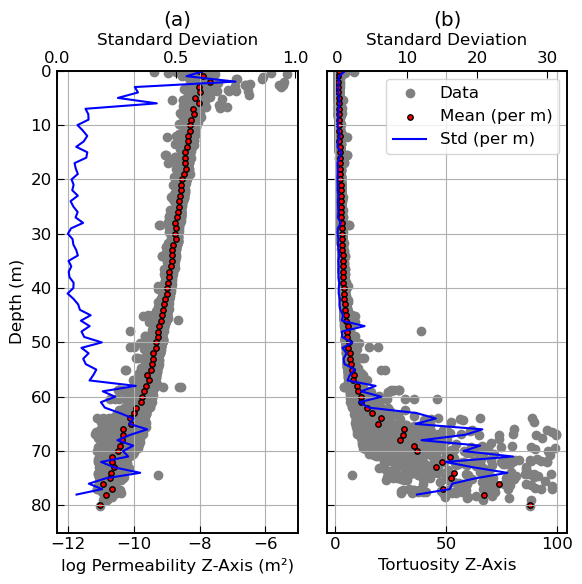

In [51]:
# Sort data by depth for smooth plotting
df = data.sort_values(by="new_depth")


df = df[df["Perm_z"] > 5e-14]
df = df[df["Perm_z"] < 5e-6]

df = df[df["Tort_z"] > 1]
df = df[df["Tort_z"] < 100]



# Create figure with shared y-axis
fig, axes = plt.subplots(1, 2, figsize=(6, 6), sharey=True)

# Apply academic-style formatting
plt.rcParams.update({
    "font.size": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5
})

# Plot configs
params = [
    ("log_perm_z", "log Permeability Z-Axis (m²)"),
    #("anisotropy_Perm", "Permeability Anisotropy"),
    #("anisotropy_Tort", "Tortuosity Anisotropy"),
    ("Tort_z", "Tortuosity Z-Axis")
]
titles = ['(a)','(b)','(c)','(d)']

for ax, (col, xlabel), axtitle in zip(axes, params, titles):
    y = df["new_depth"]
    x = df[col]
    df["depth_bin"] = df["new_depth"].astype(int)
    grouped = df.groupby("depth_bin")[col]

    mean_per_bin = grouped.mean()
    std_per_bin = grouped.std()
    depth_bins = mean_per_bin.index

 # Fit polynomial (degree 4)
    coeffs = np.polyfit(y, x, deg=4)
    poly = np.poly1d(coeffs)
    y_fit = np.linspace(y.min(), 80, 140)
    x_fit = poly(y_fit)

    # Main plot elements
    #ax.plot(x_fit, y_fit, color='orange', linewidth=2, label='Quadratic Fit')
    ax.scatter(x,y, color='gray' , label = 'Data')
    ax.scatter(mean_per_bin, depth_bins, color='Red', edgecolors='black', s=15, label='Mean (per m)')
    

    # Std on top axis
    ax_top = ax.twiny()
    ax_top.grid(False)
    ax_top.plot(std_per_bin, depth_bins, color='Blue', label='Std (per m)')
    ax_top.set_xlabel('Standard Deviation')
    ax.set_title(axtitle)
    # Labels and grid
    ax.set_xlabel(xlabel)
    ax.grid(True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.set_ylim(0,85)


# Shared y-label and inverted axis
axes[0].set_ylabel("Depth (m)")
axes[0].invert_yaxis()

# --- Combine legends ---
lines_labels = ax.get_legend_handles_labels()
lines_labels2 = ax_top.get_legend_handles_labels()
handles = lines_labels[0] + lines_labels2[0]
labels = lines_labels[1] + lines_labels2[1]

ax.legend(handles, labels, loc="upper right") 

plt.tight_layout()
plt.savefig("fig_transport.png", dpi=600, bbox_inches='tight')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


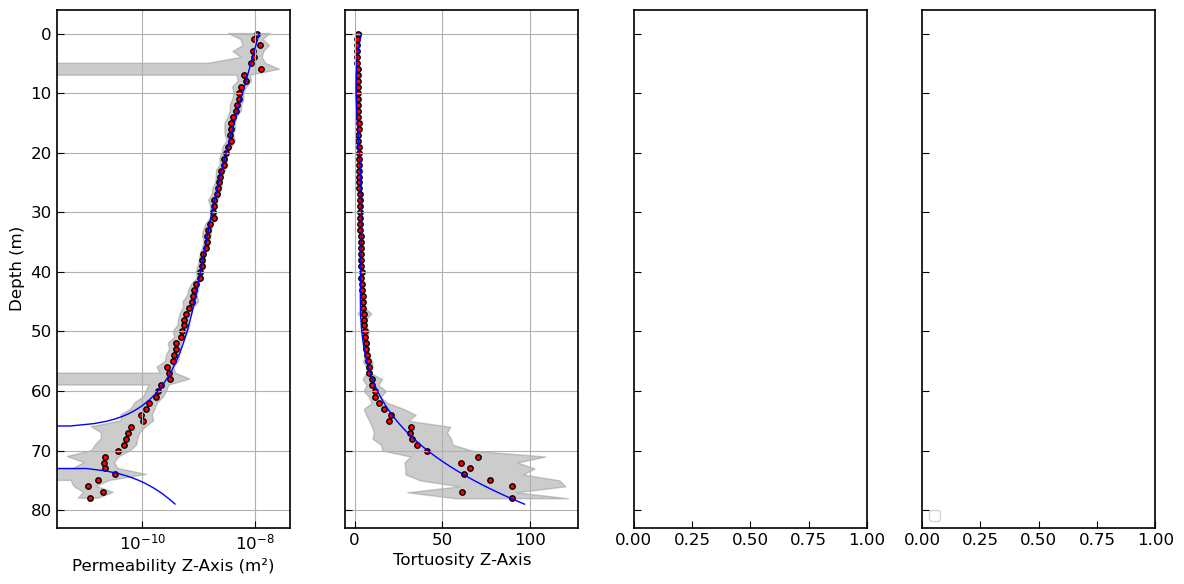

In [86]:
# Keep only necessary columns and drop NaNs
#df = df[["new_depth", "porosity", "SSA", "MIL_z"]].dropna()


# Create figure with shared y-axis
fig, axes = plt.subplots(1, 4, figsize=(12, 6), sharey=True)




# Apply academic-style formatting
plt.rcParams.update({
    "font.size": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5
})

# Plot configs
params = [
    ("Perm_z", "Permeability Z-Axis (m²)"),
    #("anisotropy_Perm", "Permeability Anisotropy"),
    #("anisotropy_Tort", "Tortuosity Anisotropy"),
    ("Tort_z", "Tortuosity Z-Axis")
    
]


titles = ['(a)','(b)','(c)','(d)']

depth = df["new_depth"]

for ax, (col, xlabel ) in zip(axes, params):

    
    if col == "Tort_z":
        
        df = data.copy()
        # Sort data by depth for smooth plotting
        df = df.sort_values(by="new_depth")
        #df = df[df["new_depth"] < 90]
        df = df[df["new_depth"] < 100]
        df = df[df["Tort_z"] > 1]
        df = df[df["Tort_z"] < 150]
        
        # Subset for depth >= 50
        df_fit = df[df["new_depth"] < 80].copy()
        y = df_fit["new_depth"]
        x = df_fit[col]
        df_fit["depth_bin"] = df_fit["new_depth"].astype(int)
        grouped = df_fit.groupby("depth_bin")[col]
        
        
        
    elif col == "Perm_z":
        
        df = data.copy()
        # Sort data by depth for smooth plotting
        df = df.sort_values(by="new_depth")
        #df = df[df["new_depth"] < 90]
        df = df[df["new_depth"] < 100]
        df = df[df["Perm_z"] > 5e-12]
        df = df[df["Perm_z"] < 5e-8]
        
        # Subset for depth >= 50
        df_fit = df[df["new_depth"] < 80].copy()
        y = df_fit["new_depth"]
        x = df_fit[col]
        df_fit["depth_bin"] = df_fit["new_depth"].astype(int)
        grouped = df_fit.groupby("depth_bin")[col]
        ax.set_xscale('log')
    else:
        x = df[col]
        y = df["new_depth"]
        df["depth_bin"] = df["new_depth"].astype(int)
        grouped = df.groupby("depth_bin")[col]

    
    mean_per_bin = grouped.mean()
    std_per_bin = grouped.std()
    depth_bins = mean_per_bin.index

            # Fit quadratic
    coeffs = np.polyfit(y, x, deg=4)
    poly = np.poly1d(coeffs)
            # Generate smooth depth range from 50 to max
    y_fit = np.linspace(y.min(), y.max(), 200)
    x_fit = poly(y_fit)
    ax.plot(x_fit, y_fit, color='blue', linewidth=1, label='Quadratic Fit')
            # Plot ± std dev band around the bin means
    ax.fill_betweenx(depth_bins, mean_per_bin - std_per_bin, mean_per_bin + std_per_bin, color='gray', alpha=0.4, label='±1 Std (per m)')
    ax.scatter(mean_per_bin,depth_bins,color='Red', edgecolors='black', s=15, label='Mean (per m)')
    
    # Labels and grid
    ax.set_xlabel(xlabel)
    ax.grid(True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)

# Shared y-label and inverted axis
axes[0].set_ylabel("Depth (m)")
axes[0].invert_yaxis()  # Depth increases downward

# Layout adjustments
plt.legend(loc='lower left', fontsize=10)

plt.tight_layout()
plt.savefig("fig_transport.png", dpi=600, bbox_inches='tight')
plt.show()

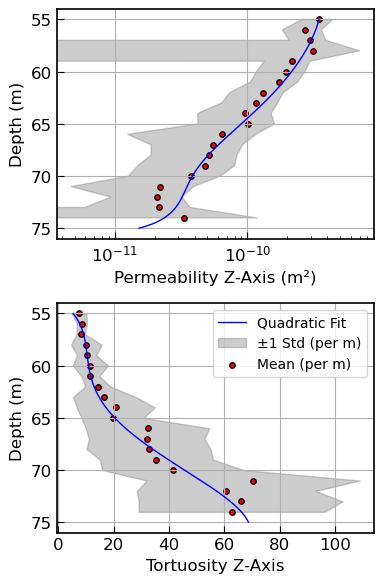

In [87]:
# Keep only necessary columns and drop NaNs
#df = df[["new_depth", "porosity", "SSA", "MIL_z"]].dropna()


# Create figure with shared y-axis
#fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharey=True)
fig, axes = plt.subplots(2, 1, figsize=(4, 6))
# Apply academic-style formatting
plt.rcParams.update({
    "font.size": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5
})

# Plot configs
params = [
    ("Perm_z", "Permeability Z-Axis (m²)"),
    ("Tort_z", "Tortuosity Z-Axis")
    
]

depth = df["new_depth"]

for ax, (col, xlabel) in zip(axes, params):

    
    if col == "Tort_z":
        
        df = data.copy()
        # Sort data by depth for smooth plotting
        df = df.sort_values(by="new_depth")
        df = df[df["new_depth"] < 75]
        df = df[df["new_depth"] > 55]
        df = df[df["Tort_z"] > 1]
        df = df[df["Tort_z"] < 150]
        
        # Subset for depth >= 50
        df_fit = df[df["new_depth"] > 55].copy()
        y = df_fit["new_depth"]
        x = df_fit[col]
        df_fit["depth_bin"] = df_fit["new_depth"].astype(int)
        grouped = df_fit.groupby("depth_bin")[col]
        
        
        
    elif col == "Perm_z":
        
        df = data.copy()
        # Sort data by depth for smooth plotting
        df = df.sort_values(by="new_depth")
        df = df[df["new_depth"] < 75]
        df = df[df["new_depth"] > 55]
        
        df = df[df["Perm_z"] > 5e-12]
        df = df[df["Perm_z"] < 5e-8]
        
        # Subset for depth >= 50
        df_fit = df[df["new_depth"] > 55].copy()
        y = df_fit["new_depth"]
        x = df_fit[col]
        df_fit["depth_bin"] = df_fit["new_depth"].astype(int)
        grouped = df_fit.groupby("depth_bin")[col]
        ax.set_xscale('log')

    else:
        x = df[col]
        y = df["new_depth"]
        df["depth_bin"] = df["new_depth"].astype(int)
        grouped = df.groupby("depth_bin")[col]

    
    mean_per_bin = grouped.mean()
    std_per_bin = grouped.std()
    depth_bins = mean_per_bin.index

            # Fit quadratic
    coeffs = np.polyfit(y, x, deg=4)
    poly = np.poly1d(coeffs)
            # Generate smooth depth range from 50 to max
    y_fit = np.linspace(y.min(), y.max(), 200)
    x_fit = poly(y_fit)
    ax.plot(x_fit, y_fit, color='blue', linewidth=1, label='Quadratic Fit')
            # Plot ± std dev band around the bin means
    ax.fill_betweenx(depth_bins, mean_per_bin - std_per_bin, mean_per_bin + std_per_bin, color='gray', alpha=0.4, label='±1 Std (per m)')
    ax.scatter(mean_per_bin,depth_bins,color='Red', edgecolors='black', s=15, label='Mean (per m)')
    
    
    # Labels and grid
    ax.set_xlabel(xlabel)
    ax.grid(True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)

# Shared y-label and inverted axis
axes[0].set_ylabel("Depth (m)")
axes[1].set_ylabel("Depth (m)")
axes[0].invert_yaxis()  # Depth increases downward
axes[1].invert_yaxis()
# Layout adjustments
plt.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig("fig_transport_zoom.png", dpi=600, bbox_inches='tight')
plt.show()

In [38]:
df = data.copy()
df.columns

Index(['name', 'number_of_regions', 'starting_layer', 'ending_layer', 'depth',
       'sample_volume', 'porosity', 'open_pores', 'cuted_pores',
       'isolated_pores', 'euler_density', 'SSA', 'MIL_x', 'MIL_y', 'MIL_z',
       'Perm_x', 'Perm_y', 'Perm_z', 'Tort_x', 'Tort_y', 'Tort_z',
       'sph_ice_cluster', 'num_pores', 'num_throats', 'coordination_number',
       'std_coordination_number', 'avg_pore_volume', 'avg_pore_diameter',
       'avg_throat_diameter', 'avg_throat_length', 'max_connections',
       'median_connections', 'num_cluster', 'max_cluster_size',
       'avg_cluster_size', 'avg_pore_surface_area', 'avg_throat_area',
       'new_depth', 'cluster_density', 'pore_density', 'throat_density',
       'anisotropy_MIL', 'anisotropy_Perm', 'anisotropy_Tort', 'density',
       'D_eff__by__D_air', 'log_perm_z', 'log_log_perm_z'],
      dtype='object')

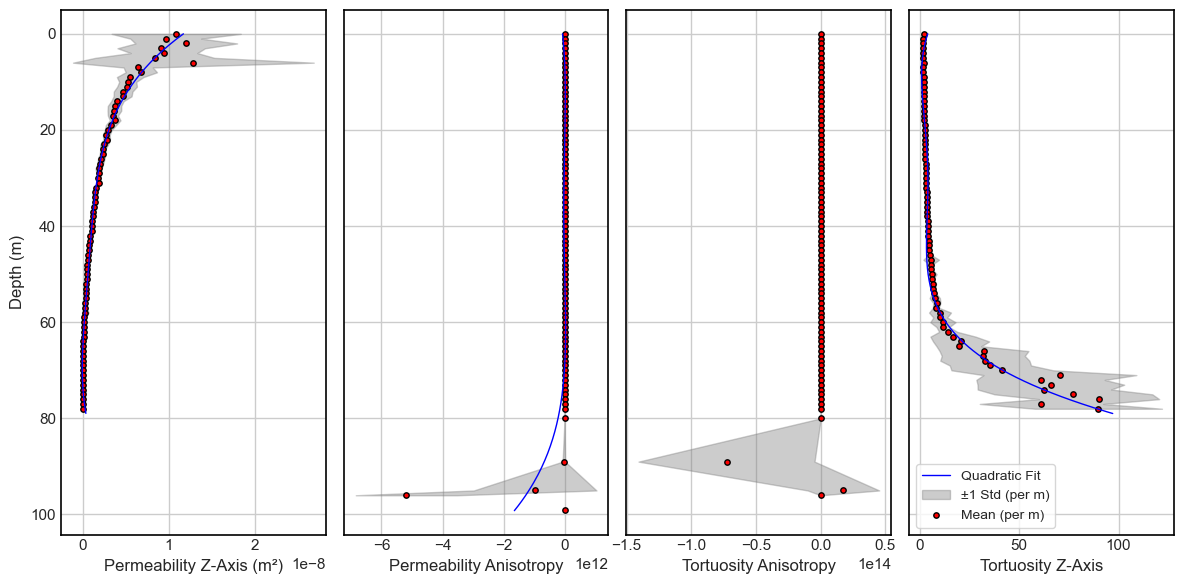

In [39]:
# Keep only necessary columns and drop NaNs
#df = df[["new_depth", "porosity", "SSA", "MIL_z"]].dropna()


# Create figure with shared y-axis
fig, axes = plt.subplots(1, 4, figsize=(12, 6), sharey=True)

# Apply academic-style formatting
plt.rcParams.update({
    "font.size": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5
})

# Plot configs
params = [
    ("Perm_z", "Permeability Z-Axis (m²)"),
    ("anisotropy_Perm", "Permeability Anisotropy"),
    ("anisotropy_Tort", "Tortuosity Anisotropy"),
    ("Tort_z", "Tortuosity Z-Axis")
    
]

depth = df["new_depth"]

for ax, (col, xlabel) in zip(axes, params):

    
    if col == "Tort_z":
        
        df = data.copy()
        # Sort data by depth for smooth plotting
        df = df.sort_values(by="new_depth")
        #df = df[df["new_depth"] < 90]
        df = df[df["new_depth"] < 100]
        df = df[df["Tort_z"] > 1]
        df = df[df["Tort_z"] < 150]
        
        # Subset for depth >= 50
        df_fit = df[df["new_depth"] < 80].copy()
        y = df_fit["new_depth"]
        x = df_fit[col]
        df_fit["depth_bin"] = df_fit["new_depth"].astype(int)
        grouped = df_fit.groupby("depth_bin")[col]
        
        
        
    elif col == "Perm_z":
        
        df = data.copy()
        # Sort data by depth for smooth plotting
        df = df.sort_values(by="new_depth")
        #df = df[df["new_depth"] < 90]
        df = df[df["new_depth"] < 100]
        df = df[df["Perm_z"] > 5e-12]
        df = df[df["Perm_z"] < 5e-8]
        
        # Subset for depth >= 50
        df_fit = df[df["new_depth"] < 80].copy()
        y = df_fit["new_depth"]
        x = df_fit[col]
        df_fit["depth_bin"] = df_fit["new_depth"].astype(int)
        grouped = df_fit.groupby("depth_bin")[col]
        
    else:
        x = df[col]
        y = df["new_depth"]
        df["depth_bin"] = df["new_depth"].astype(int)
        grouped = df.groupby("depth_bin")[col]

    
    mean_per_bin = grouped.mean()
    std_per_bin = grouped.std()
    depth_bins = mean_per_bin.index

            # Fit quadratic
    coeffs = np.polyfit(y, x, deg=4)
    poly = np.poly1d(coeffs)
            # Generate smooth depth range from 50 to max
    y_fit = np.linspace(y.min(), y.max(), 200)
    x_fit = poly(y_fit)
    ax.plot(x_fit, y_fit, color='blue', linewidth=1, label='Quadratic Fit')
            # Plot ± std dev band around the bin means
    ax.fill_betweenx(depth_bins, mean_per_bin - std_per_bin, mean_per_bin + std_per_bin, color='gray', alpha=0.4, label='±1 Std (per m)')
    ax.scatter(mean_per_bin,depth_bins,color='Red', edgecolors='black', s=15, label='Mean (per m)')
    
    
    # Labels and grid
    ax.set_xlabel(xlabel)
    ax.grid(True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)

# Shared y-label and inverted axis
axes[0].set_ylabel("Depth (m)")
axes[0].invert_yaxis()  # Depth increases downward

# Layout adjustments
plt.legend(loc='lower left', fontsize=10)

plt.tight_layout()
plt.savefig("fig_transport.png", dpi=600, bbox_inches='tight')
plt.show()

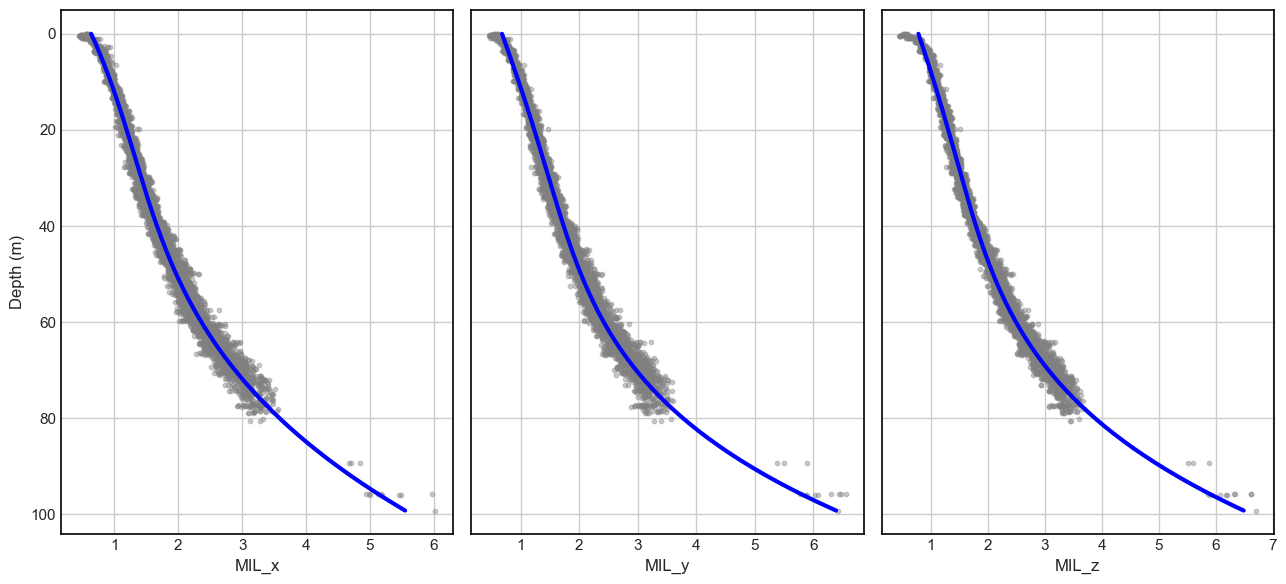

In [40]:
# Keep only necessary columns and drop NaNs
#df = df[["new_depth", "porosity", "SSA", "MIL_z"]].dropna()

# Sort data by depth for smooth plotting
df = df.sort_values(by="new_depth")

# Create figure with shared y-axis
fig, axes = plt.subplots(1, 3, figsize=(13, 6), sharey=True)

# Apply academic-style formatting
plt.rcParams.update({
    "font.size": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5
})
'MIL_x', 'MIL_y', 'MIL_z'
# Plot configs
params = [
    ("MIL_x", "MIL_x"),
    ("MIL_y", "MIL_y"),
    ("MIL_z", "MIL_z")
]

depth = df["new_depth"]

for ax, (col, xlabel) in zip(axes, params):
    x = df[col]
    y = depth
    
    # Scatter plot
    ax.scatter(x, y, color='gray', alpha=0.4, s=10, label='Data')

        # Trend line
    if col == "open_pores":
        # Subset for depth >= 50
        df_fit = df[df["new_depth"] < 90]
        y_fit_data = df_fit["new_depth"]
        x_fit_data = df_fit[col]
        # Fit quadratic
        coeffs = np.polyfit(y_fit_data, x_fit_data, deg=3)
        poly = np.poly1d(coeffs)
        # Generate smooth depth range from 50 to max
        y_fit = np.linspace(y_fit_data.min(), y_fit_data.max(), 200)
        x_fit = poly(y_fit)
        ax.plot(x_fit, y_fit, color='blue', linewidth=3, label='Quadratic Fit (depth ≥ 50)')
        ax.set_xlim(-2, 100)
        
    elif col == 'isolated_pores':
        df_fit = df[df["new_depth"] >= 65]
        y_fit_data = df_fit["new_depth"]
        x_fit_data = df_fit[col]
        
        # Fit quadratic
        coeffs = np.polyfit(y_fit_data, x_fit_data, deg=3)
        poly = np.poly1d(coeffs)

        # Generate smooth depth range from 50 to max
        y_fit = np.linspace(y_fit_data.min(),  y_fit_data.max(), 200)
        x_fit = poly(y_fit)
        ax.plot(x_fit, y_fit, color='blue', linewidth=3, label='Quadratic Fit (depth ≥ 50)')
        #ax.set_xlim(-0.1, 10)
    else:
        # Quadratic fit
        coeffs = np.polyfit(x=y, y=x, deg=4)        # x vs depth (i.e., x = f(y))
        poly = np.poly1d(coeffs)
        y_fit = np.linspace(y.min(), y.max(), 200)  # Smooth y values
        x_fit = poly(y_fit)
    
    # Plot trend line
        ax.plot(x_fit, y_fit, color='blue', linewidth=3, label='Quadratic Fit')
        #ax.set_xlim(-2, 100)
    
    # Labels and grid
    ax.set_xlabel(xlabel)
    ax.grid(True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)

# Shared y-label and inverted axis
axes[0].set_ylabel("Depth (m)")
axes[0].invert_yaxis()  # Depth increases downward

# Layout adjustments
plt.tight_layout()
plt.savefig("MIL.png", dpi=600, bbox_inches='tight')
plt.show()

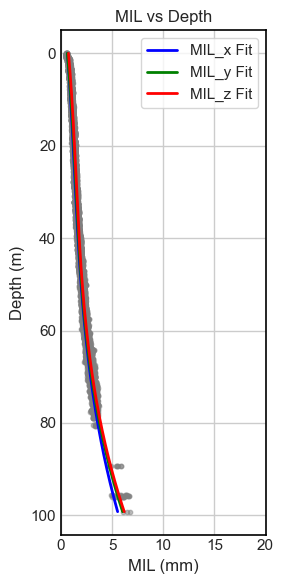

In [65]:
fig, ax = plt.subplots(figsize=(3, 6))

for mil_col, label, color in [("MIL_x", "MIL_x", 'blue'), 
                              ("MIL_y", "MIL_y", 'green'), 
                              ("MIL_z", "MIL_z", 'red')]:
    x = df["new_depth"]
    y = df[mil_col]
    
    # Scatter
    ax.scatter( y, x,color='gray', s=10, alpha=0.5)

    # Fit and plot quadratic trend
    coeffs = np.polyfit(x, y, deg=3)
    poly = np.poly1d(coeffs)
    x_fit = np.linspace(x.min(), x.max(), 300)
    y_fit = poly(x_fit)
    ax.plot( y_fit,x_fit, color=color, linewidth=2, label=f'{label} Fit')

# Style
ax.set_xlabel("MIL (mm)")
ax.set_ylabel("Depth (m)")
ax.set_title("MIL vs Depth")
ax.grid(True)
ax.legend()
ax.invert_yaxis()  # Optional: reverse depth direction
ax.set_xlim(0, 20)  # Optional
# ax.set_ylim(0, 5)    # Optional

plt.tight_layout()
plt.savefig("MIL_vs_depth.png", dpi=600, bbox_inches='tight')
plt.show()


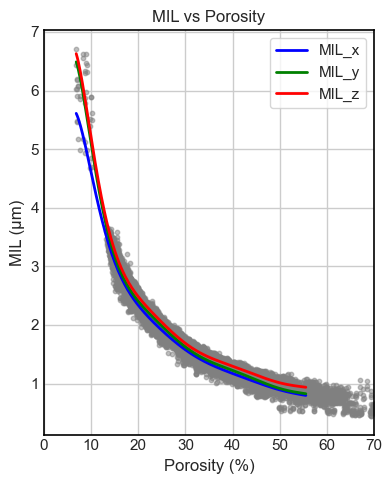

In [66]:
fig, ax = plt.subplots(figsize=(4, 5))

for mil_col, label, color in [("MIL_x", "MIL_x", 'blue'), 
                              ("MIL_y", "MIL_y", 'green'), 
                              ("MIL_z", "MIL_z", 'red')]:
    
    # Full scatter
    ax.scatter(df["porosity"], df[mil_col], color='gray', s=10, alpha=0.5)
    
    # Subset data for trend line (porosity < 60)
    mask = df["porosity"] < 100
    x_fit_data = df.loc[mask, "porosity"]
    y_fit_data = df.loc[mask, mil_col]
    
    # Fit and plot quadratic trend line
    coeffs = np.polyfit(x_fit_data, y_fit_data, deg=10)
    poly = np.poly1d(coeffs)
    x_fit = np.linspace(x_fit_data.min(), x_fit_data.max(), 300)
    y_fit = poly(x_fit)

    ax.plot(x_fit[:220], y_fit[:220], color=color, linewidth=2, label=f'{label}')

# Formatting
ax.set_xlabel("Porosity (%)")
ax.set_ylabel("MIL (µm)")
ax.set_title("MIL vs Porosity")
ax.grid(True)
ax.legend()
ax.set_xlim(0, 70)   # Full porosity range for scatter
# ax.set_ylim(0, 5)    # Optional y-limit

plt.tight_layout()
plt.savefig("MIL_vs_porosity_limited_fit.png", dpi=600, bbox_inches='tight')
plt.show()


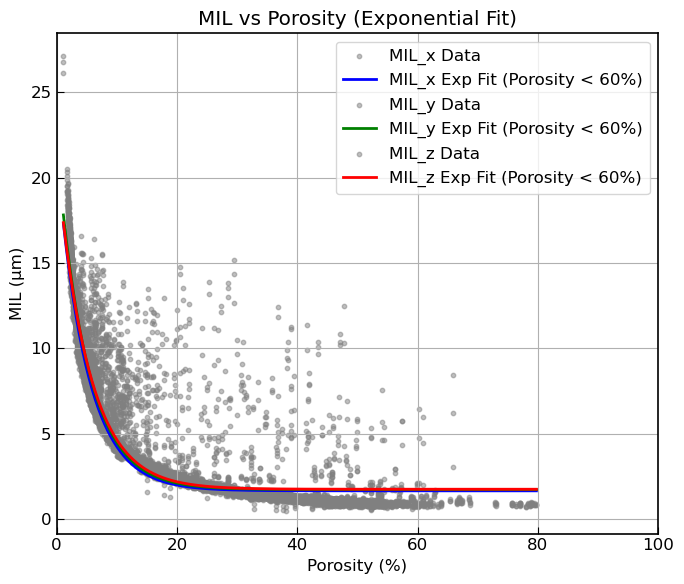

In [100]:

# Define offset exponential function
def exp_offset(x, a, b, c):
    return a * np.exp(b * x) + c
    
# Start plotting
fig, ax = plt.subplots(figsize=(7, 6))

for mil_col, label, color in [("MIL_x", "MIL_x", 'blue'), 
                              ("MIL_y", "MIL_y", 'green'), 
                              ("MIL_z", "MIL_z", 'red')]:
    
    # Full scatter plot
    ax.scatter(df["porosity"], df[mil_col], color='gray', s=10, alpha=0.5, label=f'{label} Data')

    # Subset for porosity < 60
    mask = df["porosity"] < 100
    x_data = df.loc[mask, "porosity"]
    y_data = df.loc[mask, mil_col]
    
    try:
        popt, _ = curve_fit(exp_offset, x_data, y_data, p0=(1, 0.01, 0), maxfev=10000)
        x_fit = np.linspace(x_data.min(), x_data.max(), 300)
        y_fit = exp_offset(x_fit, *popt)
        ax.plot(x_fit, y_fit, color=color, linewidth=2, label=f'{label} Exp Fit (Porosity < 60%)')
    except RuntimeError:
        print(f"Could not fit exponential with offset for {label}")

# Final formatting
ax.set_xlabel("Porosity (%)")
ax.set_ylabel("MIL (µm)")
ax.set_title("MIL vs Porosity (Exponential Fit)")
ax.grid(True)
ax.legend()
ax.set_xlim(0, 100)  # Full porosity range
# ax.set_ylim(0, 5)  # Optional

plt.tight_layout()
#plt.savefig("MIL_vs_porosity_exponential_fit.png", dpi=600, bbox_inches='tight')
plt.show()
